# Week HW 18

Last Audit: HW18

# Pips


In [107]:
%pip install gurobipy>=10
%pip install gurobipy_pandas
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

zsh:1: 10 not found
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import


In [108]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [109]:
data_size = 50
train_size = 0.8
testing_size = 0.2

# data_size = 10 # 最小要是 2
# train_size = 1
# testing_size = 0

T = 10
service_level = 0.95  # 服務水準
M = 5000000

assigned_Fs = np.arange(0.1, 1.0, 0.1)
assigned_Ts = list(range(2, T))  # 2 到 T-1

np.random.seed(0)


# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 200
MIPGAP = 0.3
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [110]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [111]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [112]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

## Visualization 

In [113]:
def plot_strategies_profits_scatter(save_type, dfs):
    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if dfs[i] is None or dfs[j] is None:
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [114]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [115]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

## Others

In [116]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [117]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [118]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [119]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "Q0_vars": Q0_vars,
        "Q1_vars": Q1_vars,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Import Data


## Data1: Training data for LR


### Making full data


In [120]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(80, 90, data_size),
        "X2": np.random.randint(1, 4, data_size),
    }
)

full_df

X1  X2
0   85.488135   2
1   87.151894   3
2   86.027634   1
3   85.448832   1
4   84.236548   3
5   86.458941   1
6   84.375872   1
7   88.917730   1
8   89.636628   1
9   83.834415   1
10  87.917250   1
11  85.288949   3
12  85.680446   1
13  89.255966   3
14  80.710361   2
15  80.871293   2
16  80.202184   2
17  88.326198   1
18  87.781568   2
19  88.700121   2
20  89.786183   2
21  87.991586   1
22  84.614794   2
23  87.805292   3
24  81.182744   1
25  86.399210   2
26  81.433533   3
27  89.446689   1
28  85.218483   3
29  84.146619   1
30  82.645556   2
31  87.742337   3
32  84.561503   3
33  85.684339   2
34  80.187898   1
35  86.176355   2
36  86.120957   2
37  86.169340   1
38  89.437481   3
39  86.818203   3
40  83.595079   3
41  84.370320   3
42  86.976312   2
43  80.602255   3
44  86.667667   3
45  86.706379   3
46  82.103826   3
47  81.289263   3
48  83.154284   1
49  83.637108   2

In [121]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [122]:
training_df, testing_df = (
    full_df[: int(data_size * train_size)],
    full_df[int(data_size * train_size) :],
)
testing_df.reset_index(drop=True, inplace=True)
print(f"training_data size: {training_df.shape}")
print(f"testing_df size: {testing_df.shape}")

training_data size: (40, 2)
testing_df size: (10, 2)


In [123]:
# #### Only for testing
# training_df = testing_df = full_df

## Data2: demand_df


### mu of each time(t)


In [124]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0.17
b2 = 0.01


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    # 設定隨機種子
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 + random_noises[t - 1]
        )

    return mu_matrix

In [125]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (50, 10)
mu_matrix[0]: 
[16.3170353  14.95314017 15.53172094 16.79387616 16.42054095 13.57570508
 15.50307137 14.40162575 14.4497641  14.96358146]


### sigma matrix


In [126]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.45998405  0.47038804  0.92437709 -0.50249371  0.15231467  0.18408386
   0.14450381 -0.55383673  0.90549802 -0.10574924]
 [ 0.69281734  0.39895855 -0.4051261   0.62759564 -0.20698852  0.76220639
   0.16254575  0.76347072  0.38506318  0.45050856]]


In [127]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((50, 10),
 array([[7.5545925 , 8.09568202, 7.77555286, 7.45064612, 7.2441454 ,
         8.16727318, 7.60421028, 7.53549838, 8.4102581 , 7.64903433],
        [7.26096999, 8.13280781, 8.09245244, 7.15371426, 7.33834024,
         8.06697829, 7.60865829, 7.1955186 , 8.53379246, 7.51941856],
        [7.97999166, 8.3604397 , 7.57858175, 7.84095898, 7.10095093,
         8.59018207, 7.72941204, 7.99994936, 8.66084101, 7.94052381],
        [6.97568302, 7.80865689, 8.06166191, 6.91939404, 7.41542125,
         7.61442659, 7.47360002, 6.8926208 , 8.1631005 , 7.28515595],
        [7.21566136, 7.78566609, 7.82449567, 7.15796688, 7.34392385,
         7.712197  , 7.47333574, 7.17010289, 8.0641764 , 7.39337687],
        [6.96551176, 7.92003796, 8.16170578, 6.89366124, 7.42087399,
         7.71979296, 7.51529444, 6.87226866, 8.31981594, 7.31380961],
        [7.73500841, 8.06762212, 7.55001869, 7.63433448, 7.1822152 ,
         8.22693234, 7.59985161, 7.74324064, 8.32081402, 7.72973532],
        [6.87197

### corr matrix


In [128]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [129]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (50, 10, 10)
cov_matrices: 
[[ 57.07186789  21.66533985  32.64735859  33.0633452  -21.22152281
   -9.96364751  -5.69140653 -15.70881574 -31.06223149  -1.20914056]
 [ 21.66533985  65.54006733  40.64398007  20.76442165 -31.31491122
   -7.84935264 -22.56841656   4.4064001    7.48669692  -3.04210621]
 [ 32.64735859  40.64398007  60.4592222   15.04679434 -24.13575082
  -15.02024548 -32.61106153   0.61888773 -27.08937775  -7.65501169]
 [ 33.0633452   20.76442165  15.04679434  55.51212758 -23.40917425
   -4.80492719   9.41812495 -35.42828362   5.58562465  13.91570037]
 [-21.22152281 -31.31491122 -24.13575082 -23.40917425  52.4776426
   21.97379258  16.54289691  16.050019    -9.36536795  -6.01475406]
 [ -9.96364751  -7.84935264 -15.02024548  -4.80492719  21.97379258
   66.70435124  40.88364187  32.03436791 -23.47358153   9.209504  ]
 [ -5.69140653 -22.56841656 -32.61106153   9.41812495  16.54289691
   40.88364187  57.82401402   2.23139988  -0.62494879  28.26058158]
 [-15.70

In [130]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [131]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301  -8.392809   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583  -4.438156   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715  -0.367832  -7.644239   8.980925  18.415047  15.679114   
11  12.047023  -3.599767  -0.488695   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336  -1.137721  -1.948502   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635  -6.768735  21.035061    4.466441  
5    8.924556  20.506724  14.01

### Replace negative values to 0


In [132]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336   0.000000   0.000000   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.01

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [133]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0         152.910061      158.145419        25.746849      10.273585   
1         155.838451      174.632897        25.374745       5.952391   
2         153.727209      197.583035        26.745804      13.115745   
3         152.743246      161.156073        24.485310       5.847203   
4         150.882363      104.317509        24.805317       7.378229   
5         154.460432      157.909283        24.631892       5.333108   
6         150.919214      158.784473        25.968599       6.616065   
7         158.640373      199.837472        24.828736       4.096907   
8         159.862499      180.569826        25.386890       8.389575   
9         149.998738      135.776355        24.908994       5.920780   
10        156.939557      105.469542        24.591520       8.124951   
11        152.671445      111.009706        24.511923       9.065769   
12        153.136989      137.637106        25.961168       6.433929   
13        159.415375      144.095565        24.497211       4.730682   
14        144.787845      125.783110        24.811917       8.639299   
15        145.061430      139.601664        25.270404       6.789124   
16        143.923944      143.002421        26.378509       8.057610   
17        157.634769      175.789290        24.406011       5.052375   
18        156.808896      177.494090        26.371455       8.722589   
19        158.370438      174.911721        24.393244       6.550731   
20        160.216744      186.291655        26.657235       5.589061   
21        157.065927      184.814983        25.435662       4.537480   
22        151.425381      135.927206        26.730020       6.131319   
23        156.949228      138.348358        25.793848       8.019133   
24        145.490897      161.878120        26.191385       4.804745   
25        154.458889      154.309997        24.286646       3.580419   
26        146.117238      140.486514        25.039229       7.064805   
27        159.539603      186.326593        24.440883      11.559800   
28        152.551653      112.992335        25.028640       5.461303   
29        150.529485      198.512230        24.555447       7.147531   
30        148.077677      155.129333        25.122499       8.671929   
31        156.842204      146.966820        25.296867       5.404812   
32        151.434787      168.863664        24.394071       5.457688   
33        153.243609      177.320162        26.050705       8.277442   
34        143.799658      151.322235        25.775033       5.970582   
35        154.080035      187.503175        24.926850       7.507997   
36        153.985859      166.698455        25.616308       4.354334   
37        153.968110      169.537008        24.447812       4.503113   
38        159.723949      151.017313        25.680068       9.711682   
39        155.271177      177.408799        26.601733       4.955730   
40        149.791866      161.524365        25.113297       6.613869   
41        151.109775      145.793015        26.003959       8.279663   
42        155.439962      117.081485        24.537374       7.363410   
43        144.704065      161.426320        26.136722       6.727145   
44        155.015266      149.198660        24.982677       5.156446   
45        155.081075      146.936399        24.687858       6.903283   
46        147.256735      118.947404        25.819711       5.357781   
47        145.871979      147.483133        24.315791       9.569238   
48        148.842514      159.007128        26.398642       7.623894   
49        149.763315      151.586792        24.239766       8.997335   

    std_relative_error  
0           150.612122  
1           326.294994  
2           103.921356  
3           318.752544  
4           236.196096  
5           361.867489  
6           292.508217  
7           506.036063  
8           202.600442  
9           320.704576  
10          202.666667  
11          170.378852  
12    

### Validate normal distribution


In [134]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336   0.000000   0.000000   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.01

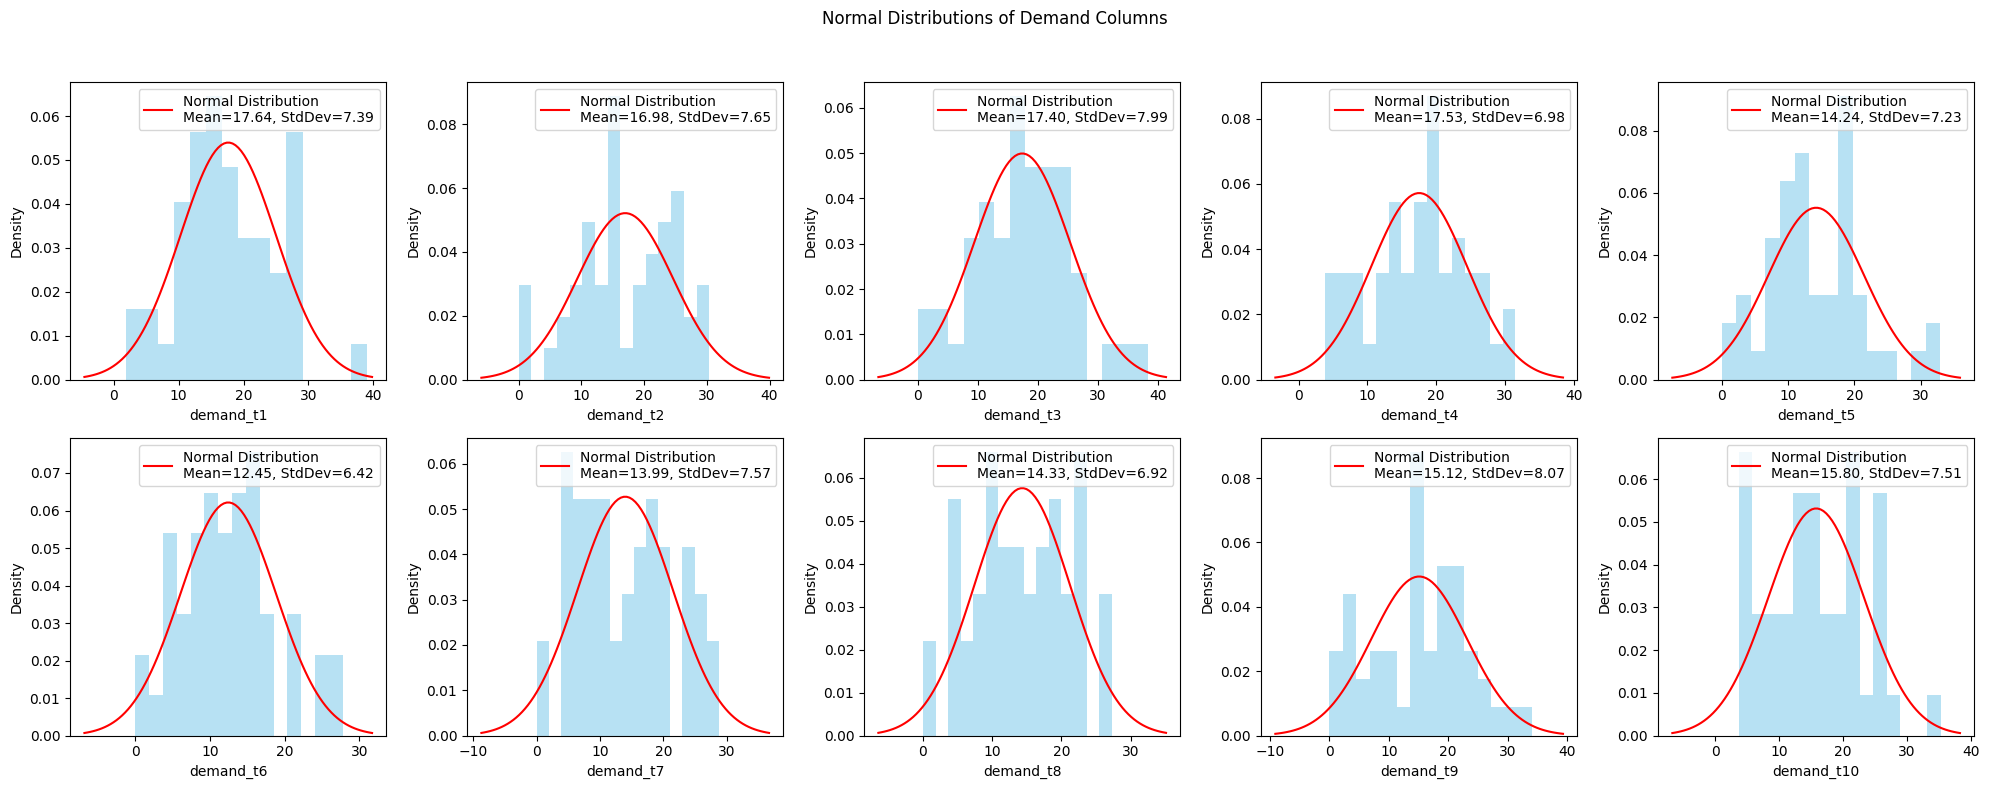

In [135]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [136]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   55.766964  10.782769  34.541064  15.610473 -22.067285 -15.672412   
demand_t2   10.782769  59.641856  39.946127   8.752040 -26.123491  -9.565768   
demand_t3   34.541064  39.946127  65.129320   4.508503 -27.055220 -22.527053   
demand_t4   15.610473   8.752040   4.508503  49.683684 -26.033199  -4.309596   
demand_t5  -22.067285 -26.123491 -27.055220 -26.033199  53.289792  16.426599   
demand_t6  -15.672412  -9.565768 -22.527053  -4.309596  16.426599  42.039488   
demand_t7  -14.237829 -23.130424 -41.512849  13.634396  15.589577  34.023116   
demand_t8   -5.055418  12.072126  10.341245 -33.861804  16.594622  17.618905   
demand_t9  -37.621091  13.294656 -25.470477  17.901233  -4.041189  -0.831385   
demand_t10   9.116602   5.493815   2.799311  25.764294 -10.585068   4.447678   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1  -14.237829  -5.055418 -37.621091    9.116602  
demand_t2  -23.130424  12.072126  13.294656    5.493815  
demand_t3  -41.512849  10.341245 -25.470477    2.799311  
demand_t4   13.634396 -33.861804  17.901233   25.764294  
demand_t5   15.589577  16.594622  -4.041189  -10.585068  
demand_t6   34.023116  17.618905  -0.831385    4.447678  
demand_t7   58.426763  -8.649191  13.106096   23.219900  
demand_t8   -8.649191  48.903194 -13.356216   -2.123279  
demand_t9   13.106096 -13.356216  66.464454   19.876099  
demand_t10  23.219900  -2.123279  19.876099   57.502926

In [137]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.568140  10.004661   2.628399  15.853017   1.284401   6.202917   
demand_t2   10.004661   4.133804   0.462692  11.209802   4.988853   2.010715   
demand_t3    2.628399   0.462692   3.530349  10.228850   2.523465   7.776303   
demand_t4   15.853017  11.209802  10.228850   3.252114   3.059817   0.265908   
demand_t5    1.284401   4.988853   2.523465   3.059817   0.018819   5.156850   
demand_t6    6.202917   2.010715   7.776303   0.265908   5.156850  21.507331   
demand_t7    8.734762   1.011158   8.855333   4.509445   0.973790   5.612774   
demand_t8    9.819686   7.858623   9.738607   0.244588   0.931507  12.729927   
demand_t9    7.847976   6.009551   1.480574  12.537210   5.263269  21.754057   
demand_t10  10.275277   8.444497  10.375493  12.402330   4.628138   4.393941   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    8.734762   9.819686   7.847976   10.275277  
demand_t2    1.011158   7.858623   6.009551    8.444497  
demand_t3    8.855333   9.738607   1.480574   10.375493  
demand_t4    4.509445   0.244588  12.537210   12.402330  
demand_t5    0.973790   0.931507   5.263269    4.628138  
demand_t6    5.612774  12.729927  21.754057    4.393941  
demand_t7    1.326413  10.799517  13.718487    4.399167  
demand_t8   10.799517   4.716168   1.028514    9.307942  
demand_t9   13.718487   1.028514   2.382624    2.269641  
demand_t10   4.399167   9.307942   2.269641    0.877051

### Validate the corr matrix of damand_df is close to original setting


In [138]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.186968   0.573138   0.296566  -0.404798  -0.323682   
demand_t2    0.186968   1.000000   0.640930   0.160778  -0.463376  -0.191036   
demand_t3    0.573138   0.640930   1.000000   0.079257  -0.459241  -0.430514   
demand_t4    0.296566   0.160778   0.079257   1.000000  -0.505940  -0.094298   
demand_t5   -0.404798  -0.463376  -0.459241  -0.505940   1.000000   0.347054   
demand_t6   -0.323682  -0.191036  -0.430514  -0.094298   0.347054   1.000000   
demand_t7   -0.249430  -0.391834  -0.672959   0.253060   0.279387   0.686498   
demand_t8   -0.096805   0.223532   0.183238  -0.686965   0.325070   0.388581   
demand_t9   -0.617943   0.211158  -0.387128   0.311517  -0.067904  -0.015728   
demand_t10   0.160990   0.093811   0.045742   0.482021  -0.191217   0.090461   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -0.249430  -0.096805  -0.617943    0.160990  
demand_t2   -0.391834   0.223532   0.211158    0.093811  
demand_t3   -0.672959   0.183238  -0.387128    0.045742  
demand_t4    0.253060  -0.686965   0.311517    0.482021  
demand_t5    0.279387   0.325070  -0.067904   -0.191217  
demand_t6    0.686498   0.388581  -0.015728    0.090461  
demand_t7    1.000000  -0.161808   0.210316    0.400599  
demand_t8   -0.161808   1.000000  -0.234272   -0.040040  
demand_t9    0.210316  -0.234272   1.000000    0.321508  
demand_t10   0.400599  -0.040040   0.321508    1.000000

In [139]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [140]:
demand_df_train, demand_df_test = (
    demand_df[: int(data_size * train_size)],
    demand_df[int(data_size * train_size) :],
)
print(f"demand_df_train size: {demand_df_train.shape}")
print(f"demand_df_test size: {demand_df_test.shape}")

demand_df_test.reset_index(drop=True, inplace=True)

demand_df_train size: (40, 10)
demand_df_test size: (10, 10)


In [141]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [142]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [143]:
Q_star = calculate_Q_star(demand_df_train, service_level=0.95)

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
95.0 percentile of sum: 199.5378903943182


## Data3: Qk hat df


### Functions


In [144]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [145]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [146]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    print(f"        mean_Y: {mean_Y}")
    print(f"        sd_Y: {sd_Y}")
    print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [147]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    print(f"mu_matrix: {mu_matrix}")
    print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [148]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            print(f"    x_observed: {x_observed}")
            print(f"    mu_cond: {mu_cond}")
            print(f"    sigma_cond: \n{sigma_cond}")
            print(f"    Qk_hat: {Qk_hat}")
            print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [149]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [150]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [151]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
        mean_Y: 69.23076923076923
        sd_Y: 4.260733053577301
    percentile_95_Y: 76.23905144741786
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

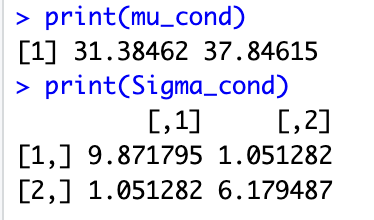
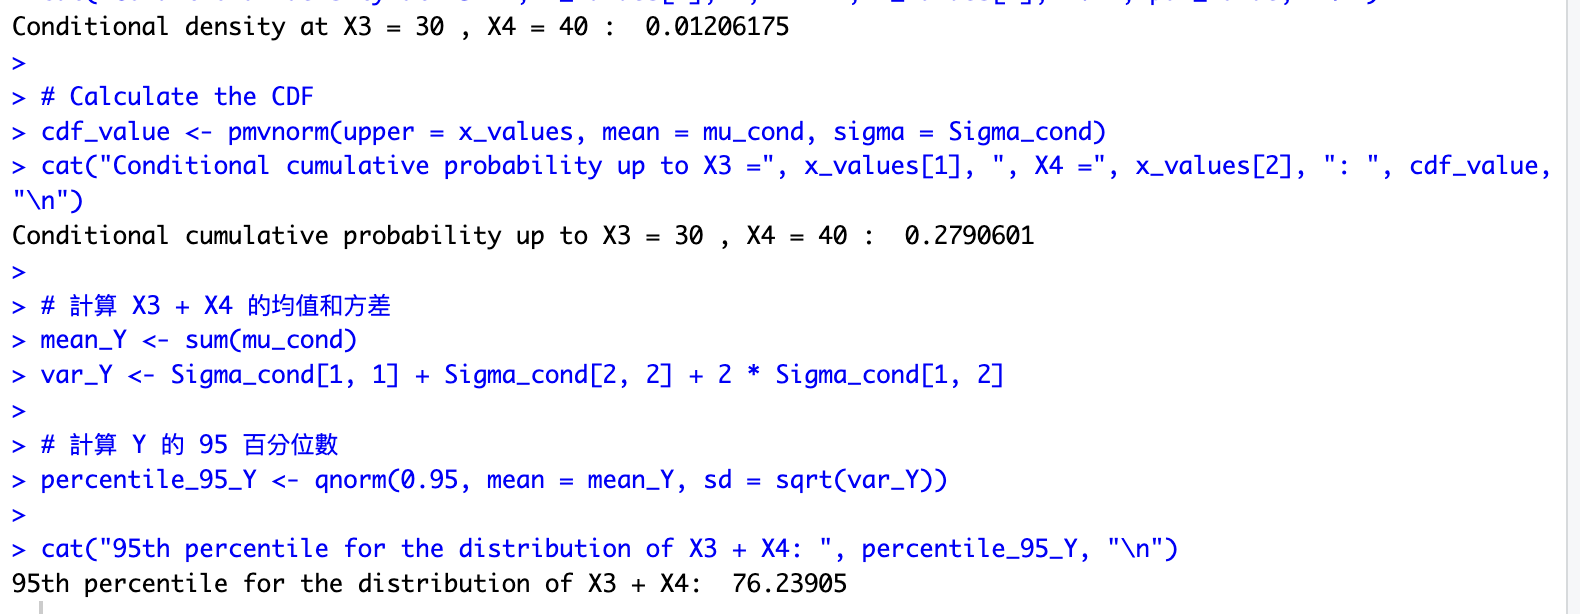


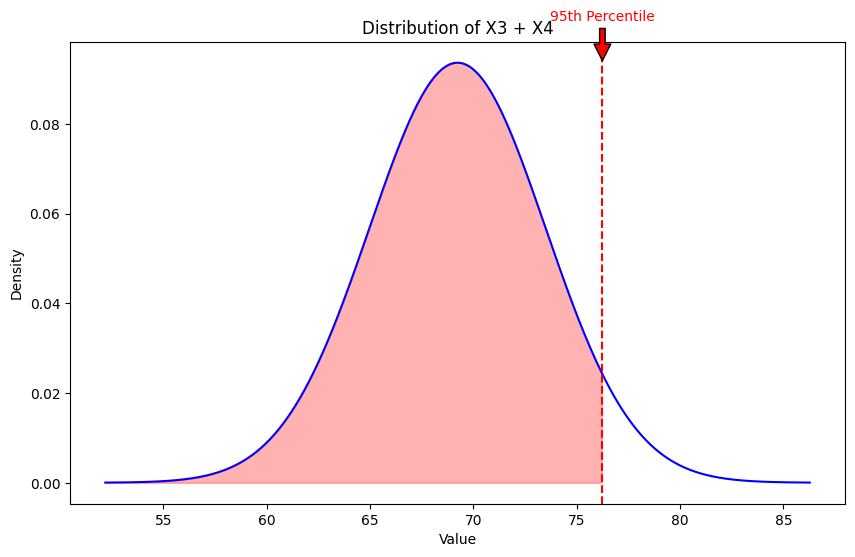

In [152]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


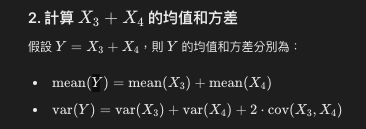


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [153]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.014943323554928
模擬計算的Y的方差: 2.961260737816822


### Calculate Qk hat for 2~T-1 of demand_df_train


In [154]:
demand_df_train

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.015789   12.841424  
6    7.473511  17.906391  22.168582   18.965401  
7   23.357246  21.838296  17.816820   26.805897  
8   12.086433  27.274418   8.934028   21.344027  
9   16.861946  12.320182   0.238896    8.544022  
10  17.778682   8.409496  25.272118    8.758444  
11  20.938378  15.602594   5.379306    3.662172  
12  23.778078   0.631211  18.819244   13.554523  
13   9.237258  16.921415   9.566006   11.621436  
14   4.024678   9.054851   3.711701   17.887787  
15   6.227981  23.292854  10.670875    7.410580  
16  11.018282  20.942456   0.000000    9.689252  
17  24.370603  19.121483  15.207288   16.801672  
18   7.392028  19.074638  31.479587   27.421621  
19   6.345097  18.073256  14.712353   14.301498  
2

In [155]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

mu_matrix: [16.85929352 17.64208003 17.40539246 17.27750222 14.9452113  13.25144508
 14.55940354 14.853123   15.43293702 15.65264964]
covariance_matrix: 
[[ 5.64723956e+01  1.18594082e+01  3.43466372e+01  1.38426555e+01
  -1.66913909e+01 -1.27935054e+01 -1.49262702e+01 -3.84331959e-02
  -4.09863740e+01  4.05616662e+00]
 [ 1.18594082e+01  6.46671989e+01  4.64620150e+01  1.05481991e+01
  -2.94529918e+01 -1.23617948e+01 -3.03585130e+01  1.45910687e+01
   1.43480026e+01  6.85598630e+00]
 [ 3.43466372e+01  4.64620150e+01  7.16692411e+01  4.24824557e+00
  -2.64983973e+01 -2.42997906e+01 -4.93872371e+01  1.40154826e+01
  -2.54886928e+01 -1.68082440e+00]
 [ 1.38426555e+01  1.05481991e+01  4.24824557e+00  4.77523725e+01
  -1.82898076e+01 -4.27643167e+00  1.08492715e+01 -2.84351533e+01
   2.14090919e+01  2.55695743e+01]
 [-1.66913909e+01 -2.94529918e+01 -2.64983973e+01 -1.82898076e+01
   3.92999709e+01  1.34369964e+01  1.87455199e+01  5.72692099e+00
  -6.81809319e+00 -7.23117239e+00]
 [-1.279350

In [156]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

mu_matrix: [17.63876624 16.98263282 17.40056963 17.5274631  14.24154567 12.44973395
 13.98906034 14.33363245 15.11520152 15.80431854]
covariance_matrix: 
[[ 55.76696393  10.78276942  34.54106363  15.61047299 -22.06728496
  -15.67241175 -14.237829    -5.05541756 -37.62109112   9.11660212]
 [ 10.78276942  59.64185557  39.94612678   8.75203978 -26.12349146
   -9.56576781 -23.13042397  12.07212579  13.29465588   5.49381548]
 [ 34.54106363  39.94612678  65.12932033   4.50850286 -27.05521991
  -22.52705301 -41.51284936  10.34124515 -25.4704774    2.79931095]
 [ 15.61047299   8.75203978   4.50850286  49.6836842  -26.03319918
   -4.3095965   13.63439613 -33.8618042   17.90123324  25.7642936 ]
 [-22.06728496 -26.12349146 -27.05521991 -26.03319918  53.2897921
   16.42659886  15.58957722  16.5946224   -4.04118905 -10.58506841]
 [-15.67241175  -9.56576781 -22.52705301  -4.3095965   16.42659886
   42.03948795  34.02311649  17.61890478  -0.83138518   4.4476775 ]
 [-14.237829   -23.13042397 -41.51284

In [157]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   196.730270  165.826129  170.767696  164.483383  180.630479  172.720206   
1   199.607045  188.456931  191.182679  183.697352  186.587644  196.303469   
2   206.446866  213.224977  208.277036  211.053997  219.611235  207.365540   
3   191.125522  199.996131  202.214532  186.856165  179.846442  173.869865   
4   191.963485  181.266862  175.346405  178.657669  172.404570  142.544474   
5   194.071228  201.084336  196.725560  191.340168  183.094855  178.608682   
6   189.304215  198.557499  187.817342  188.253073  180.342661  169.096824   
7   191.851286  187.351065  183.955334  185.889249  192.387174  206.002113   
8   199.752189  204.225613  201.950739  192.727617  174.245381  182.336967   
9   197.196812  186.145061  181.549866  175.308539  170.487584  167.247117   
10  185.859726  160.519193  158.953480  153.998174  135.612063  127.275770   
11  191.376036  163.212223  167.333128  155.894059  156.266144  146.897549   
12  191.987546  177.371607  178.292770  179.660249  179.193437  163.640465   
13  196.862122  191.045691  186.232560  179.178478  171.833760  164.248186   
14  199.703054  182.937237  173.418044  173.618522  157.006127  145.588989   
15  193.246965  198.196274  197.215043  180.440732  178.311494  166.094808   
16  200.478547  195.451011  194.773613  177.587899  166.686793  165.097245   
17  191.150500  184.371600  185.750255  185.870845  183.778965  201.105703   
18  187.842153  200.651668  194.474165  194.733472  196.142656  175.637322   
19  197.065193  210.942169  212.912676  207.996493  208.342527  207.393615   
20  198.516126  187.676266  186.604703  194.473057  210.919847  202.824505   
21  192.135716  186.358342  187.585269  187.363865  195.073937  204.568652   
22  194.308083  196.579512  198.931687  200.525371  198.589254  181.497871   
23  198.354131  200.573578  208.795682  208.702645  201.255259  181.283243   
24  193.821176  187.942943  180.214878  187.487711  194.827981  181.969547   
25  191.528323  175.707745  171.469903  172.391161  161.267306  160.230290   
26  194.259900  202.143772  207.519039  208.679344  201.621576  185.052967   
27  193.872500  187.959822  200.600610  208.590865  203.623810  178.555260   
28  193.638442  175.584500  165.274906  162.373411  157.717219  148.836656   
29  197.818461  202.473447  208.446523  211.682714  200.474879  212.499087   
30  196.639444  198.372114  185.692545  185.150490  184.579399  188.515907   
31  192.527108  192.089307  186.489075  177.974184  177.228795  178.438730   
32  192.730534  206.134884  209.128112  208.176709  204.754403  193.232589   
33  185.659887  191.124125  191.487987  198.113541  191.320885  205.027405   
34  187.843968  179.162850  177.714756  170.695254  161.294299  149.735273   
35  192.786547  199.158780  197.548202  210.746727  209.891919  208.555317   
36  194.132044  178.128121  178.431429  178.864290  178.834786  185.426502   
37  194.689254  184.957054  191.370075  192.149242  184.295892  180.792919   
38  193.024898  204.809342  190.863493  187.815006  196.589574  179.319936   
39  190.702347  197.077351  200.043866  188.593440  189.534567  184.422320   
40  196.145480  196.707565  207.023535  210.456976  206.749142  198.731825   
41  200.603501  196.128688  190.605383  182.723210  169.666608  159.211866   
42  190.636315  170.800910  169.398866  158.771382  157.851148  146.819163   
43  196.322581  180.880288  179.661601  186.436603  179.893920  174.788955   
44  195.098993  185.447093  186.719804  186.851241  180.419352  159.213240   
45  198.344736  189.412117  185.187612  187.117985  170.374207  180.329888   
46  190.948148  180.181194  176.949876  182.070403  154.348563  143.770878   
47  200.314121  202.907750  205.153755  199.312080  178.405977  156.215852   
48  193.428558  186.821950  184.874792  169.882511  186.405537  169.331067   
49  200.589327  178.784185  170.721462  176.954892  172.103367  160.564783   

     Qk_hat_k8   Qk_hat_k9

### Plot the distribuction


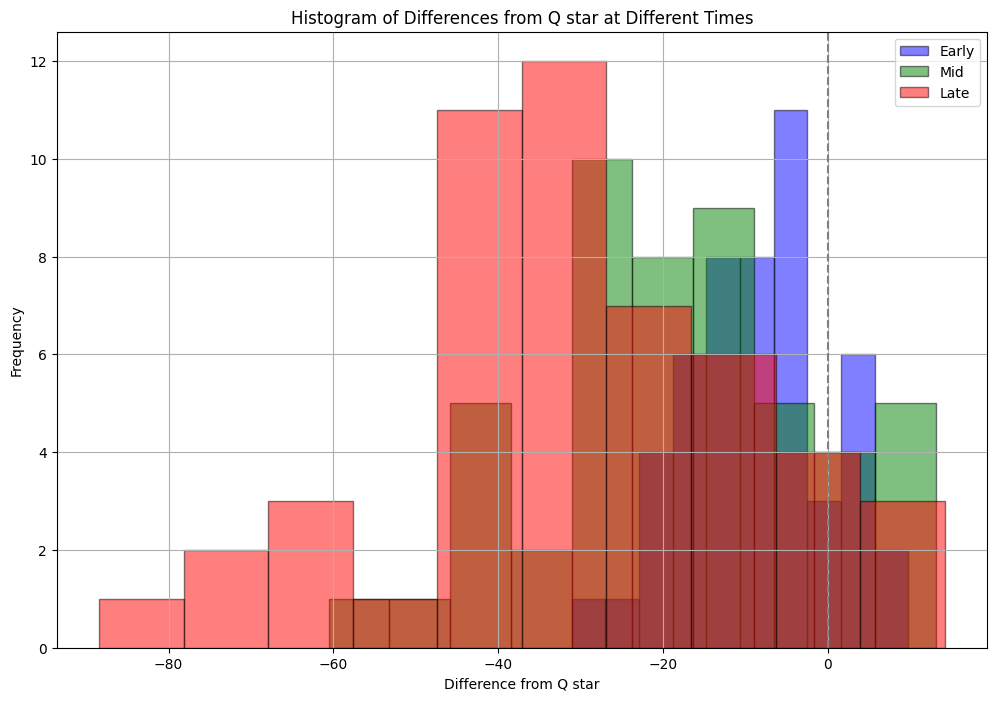

Q_star is: 199.5378903943182
Early bias: -8.55380618586113
Mid bias: -17.80498874912759
Late bias: -30.677114450352974


In [158]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

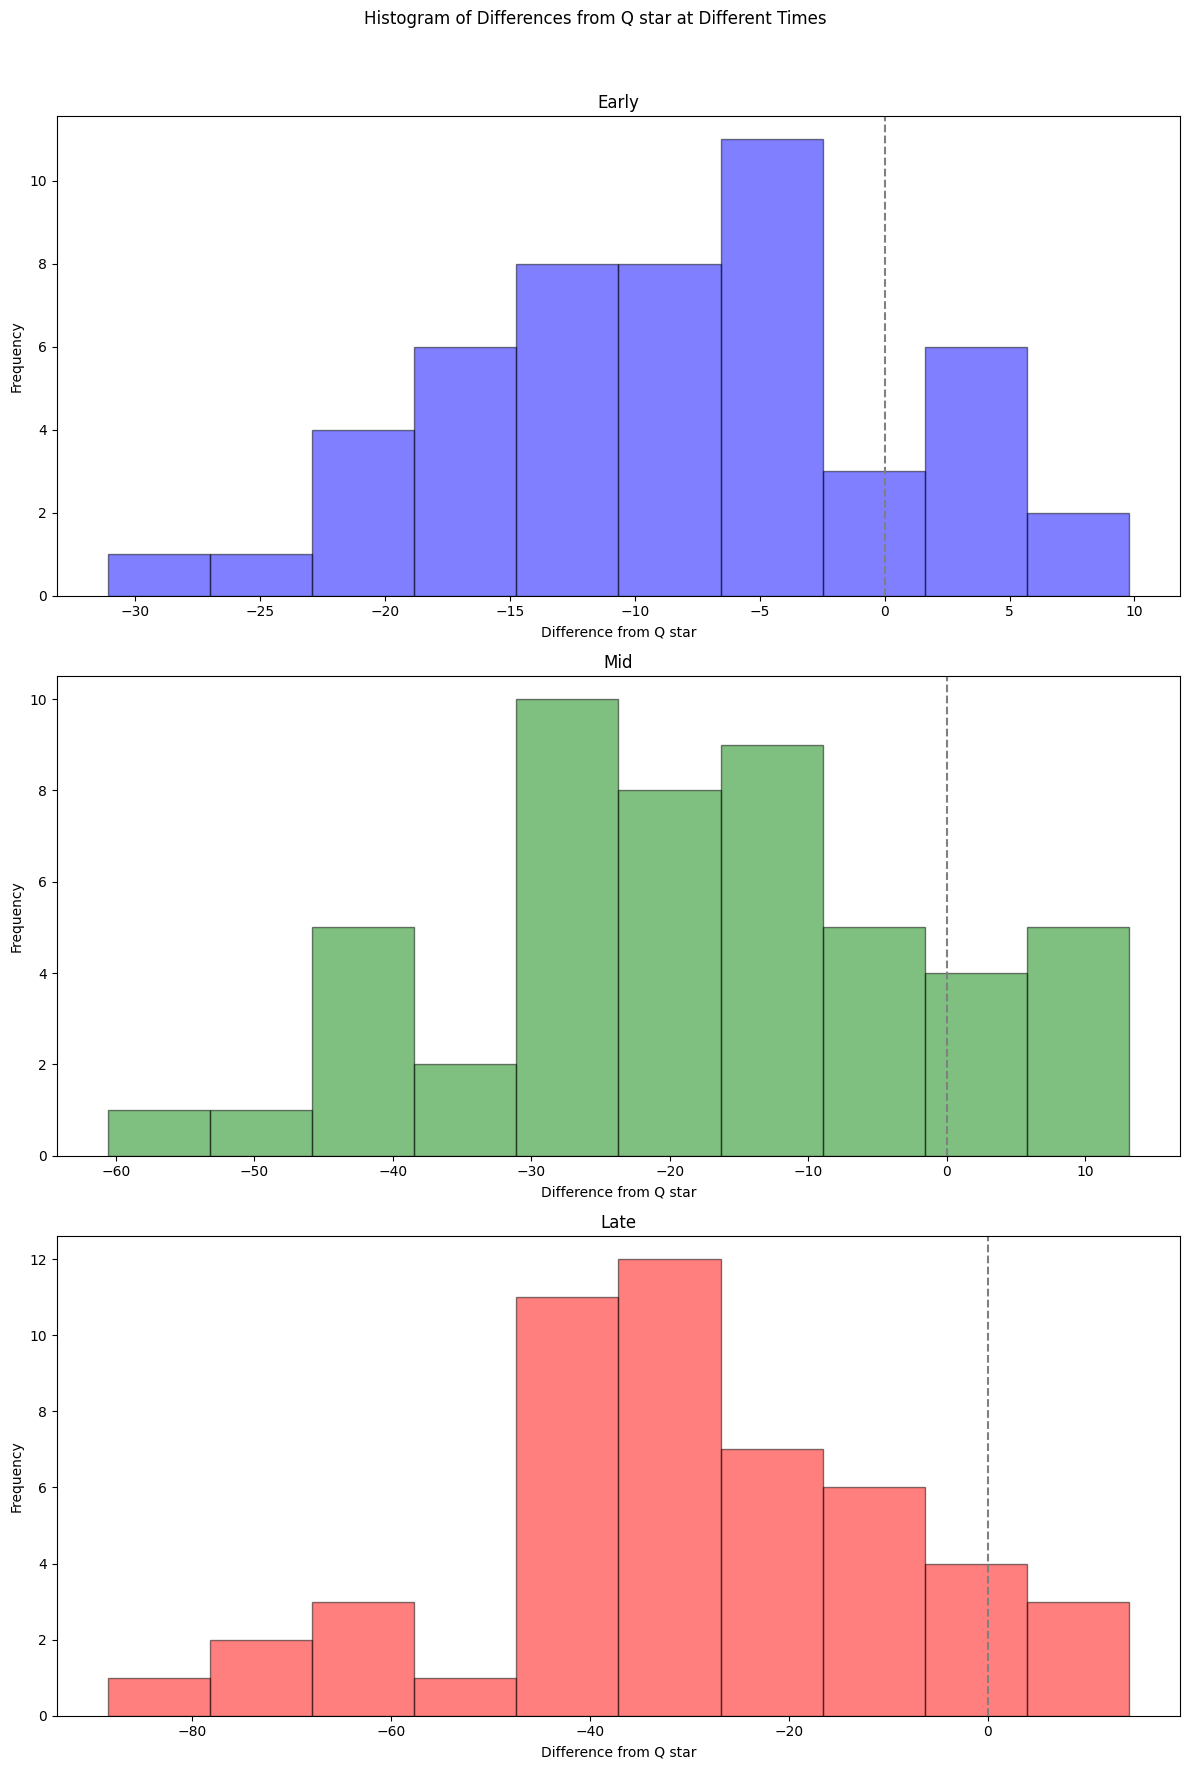

In [159]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## One-time Procurement


In [160]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## (1)Grid for Fixed F & Fixed Rk


In [161]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": Q0,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
    }

    return result_df, stimulation_result

In [162]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    print(f"Q_star: {Q_star}")
    results_list = []
    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [163]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [164]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (4)Grid for Fixed F & Flexible Rk(s6)


In [165]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [166]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

            print(f"beta_values: \n{beta_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [167]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [168]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [169]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None
        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [170]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


這是將 tau = beta + f 進行計算的部分


In [171]:
def __fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept
        # gamma = model.addVar(1, name="gamma")  # gamma

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            # model.addGenConstrMax(Q1_vars[i], [Q_hat_adjusteds[i]], 0.0, name=f"Q1_var_{i}")
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )  # 計算 Q1 = max(Q_hat_adjusted, 0) 的線性替代
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [172]:
def fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_3(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (7)Beta with softmax


In [173]:
def __fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)

            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [174]:
def fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

# Testing Utils


## (1)Grid for Fixed F & Fixed Rk


In [175]:
# put best F and R into the model
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [176]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (4)Grid for Fixed F & Flexible Rk(s6)


In [177]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [178]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [179]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [180]:
# import alpha and beta
# put them to compute every R and F


def cal_test_fully_flexible_simple_beta_with_softmax_3(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (7)Beta with softmax


In [181]:
def cal_test_fully_flexible_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Medium)

## Setting reasonable parameters


In [182]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411060248

In [183]:
model_prefix = "med"
status = "train"

salvage_value = 0
cost = 500
price = 1000


service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [184]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
50.0 percentile of sum: 157.87903781155435
Q_star: 157.87903781155435


In [185]:
demand_df_train

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.015789   12.841424  
6    7.473511  17.906391  22.168582   18.965401  
7   23.357246  21.838296  17.816820   26.805897  
8   12.086433  27.274418   8.934028   21.344027  
9   16.861946  12.320182   0.238896    8.544022  
10  17.778682   8.409496  25.272118    8.758444  
11  20.938378  15.602594   5.379306    3.662172  
12  23.778078   0.631211  18.819244   13.554523  
13   9.237258  16.921415   9.566006   11.621436  
14   4.024678   9.054851   3.711701   17.887787  
15   6.227981  23.292854  10.670875    7.410580  
16  11.018282  20.942456   0.000000    9.689252  
17  24.370603  19.121483  15.207288   16.801672  
18   7.392028  19.074638  31.479587   27.421621  
19   6.345097  18.073256  14.712353   14.301498  
2

In [186]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

mu_matrix: [16.85929352 17.64208003 17.40539246 17.27750222 14.9452113  13.25144508
 14.55940354 14.853123   15.43293702 15.65264964]
covariance_matrix: 
[[ 5.64723956e+01  1.18594082e+01  3.43466372e+01  1.38426555e+01
  -1.66913909e+01 -1.27935054e+01 -1.49262702e+01 -3.84331959e-02
  -4.09863740e+01  4.05616662e+00]
 [ 1.18594082e+01  6.46671989e+01  4.64620150e+01  1.05481991e+01
  -2.94529918e+01 -1.23617948e+01 -3.03585130e+01  1.45910687e+01
   1.43480026e+01  6.85598630e+00]
 [ 3.43466372e+01  4.64620150e+01  7.16692411e+01  4.24824557e+00
  -2.64983973e+01 -2.42997906e+01 -4.93872371e+01  1.40154826e+01
  -2.54886928e+01 -1.68082440e+00]
 [ 1.38426555e+01  1.05481991e+01  4.24824557e+00  4.77523725e+01
  -1.82898076e+01 -4.27643167e+00  1.08492715e+01 -2.84351533e+01
   2.14090919e+01  2.55695743e+01]
 [-1.66913909e+01 -2.94529918e+01 -2.64983973e+01 -1.82898076e+01
   3.92999709e+01  1.34369964e+01  1.87455199e+01  5.72692099e+00
  -6.81809319e+00 -7.23117239e+00]
 [-1.279350

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   160.846666  133.926626  139.786695  136.099523  154.176141  149.858649   
1   164.050082  156.289344  160.346121  154.805226  159.991259  175.907386   
2   171.666527  181.112326  176.662923  183.419624  189.841218  182.296327   
3   154.605529  166.753070  171.613553  155.091998  155.563321  153.631400   
4   155.538639  148.549409  142.868449  149.422484  144.899330  118.415773   
5   157.885704  168.093303  164.987388  160.736272  156.392692  157.712542   
6   152.577424  165.176868  154.930171  157.062793  152.747686  148.073743   
7   155.413701  154.477968  152.065460  156.740317  165.242425  188.146354   
8   164.211706  171.695774  170.621613  162.458189  147.539055  162.021635   
9   161.366181  153.805150  149.392923  145.089309  142.841722  144.902201   
10  148.741832  127.720412  126.767082  123.362204  110.585652  107.581178   
11  154.884488  130.869785  136.174494  125.692168  131.289689  125.225261   
12  155.565432  144.749293  146.914452  151.291510  153.046270  142.058182   
13  160.993489  158.557359  154.157726  148.661195  144.404287  141.527187   
14  164.156993  150.910308  140.310990  144.157387  127.809560  121.470447   
15  156.967851  165.196315  166.000909  148.146563  152.824357  143.545434   
16  165.020539  163.198914  163.507451  146.256357  140.204568  142.192111   
17  154.633344  151.503408  154.625294  157.146315  158.118944  184.703385   
18  150.949353  167.083141  162.441563  164.086345  169.579440  154.133210   
19  161.219617  177.998638  182.500947  178.865637  182.387037  187.166778   
20  162.835295  155.424347  155.092525  167.755932  182.494749  180.500333   
21  155.730426  153.535753  156.476531  158.653297  168.951876  186.461948   
22  158.149453  163.718232  168.254489  172.527855  172.713457  159.963122   
23  162.654907  167.998880  179.217531  181.889805  176.272094  159.209130   
24  157.607261  155.241625  147.572768  158.870298  166.091486  159.592228   
25  155.054067  143.081765  139.153642  142.995476  134.382433  140.346814   
26  158.095799  169.145285  177.503986  181.052393  176.701199  164.369875   
27  157.664412  155.262944  171.512906  183.670991  179.731857  157.874556   
28  157.403778  143.160582  131.884868  131.459454  129.093218  125.792975   
29  162.058414  169.802905  178.524678  185.028638  175.076888  195.286960   
30  160.745527  165.688095  152.423172  154.405185  155.049771  166.938785   
31  156.166258  159.167017  154.325327  146.451003  150.293620  157.793037   
32  156.392782  172.896923  178.801981  179.475683  179.644464  173.193068   
33  148.519303  157.576819  160.378438  169.664500  166.372237  190.480653   
34  150.951374  146.106819  145.988473  139.720334  136.088876  129.192472   
35  156.455155  166.092426  166.249962  184.072626  182.856629  190.177428   
36  157.953426  145.690138  146.952075  150.481517  152.209600  166.227215   
37  158.573904  152.408840  161.118764  164.891231  159.267642  161.409203   
38  156.720570  171.630762  157.547980  155.808804  167.379885  155.266626   
39  154.134305  163.863945  169.505211  157.695075  165.004880  164.515903   

     Qk_hat_k8   Qk_hat_k9  
0   154.378176  155.673410  
1   174.372934  177.201392  
2   185.869801  187.344004  
3   155.321086  159.888785  
4   113.084371  101.690870  
5   159.044520  163.340719  
6   153.803100  161.883895  
7   188.505264  196.116594  
8   167.963201  182.450274  
9   154.612551  142.290985  
10  102.262262   93.245813  
11  119.636478  120.333066  
12  152.736648  132.843741  
13  143.035586  143.378113  
14  119.531540  120.931154  
15  140.730647  137.831271  
16  146.944120  138.886093  
17  179.147678  177.500897  
18  156.231874  171.904451  
19  175.649694  166.591896  
20  180.316977  184.855746  
21  189.229239  192.809196  
22  156.015203  143.088779  
23  141.942803  147.184616  
24  155.310378  162.791494  
25  138.514913  153.905591  
26  158.332798  146.068

## Strategies


### One-time procurement strategy


In [187]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/40 with initial inventory Q_star=157.87903781155435
--------------------------------------------------
Day 1
Demand      : 21.628300603338065
Sales       : 21.628300603338065
Loss        : 0
Left        : 136.2507372082163
Inventory   : 136.2507372082163
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 136.2507372082163
Inventory   : 136.2507372082163
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 4.140547394978338
Sales       : 4.140547394978338
Loss        : 0
Left        : 132.11018981323795
Inventory   : 132.11018981323795
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 14.794692242241718
Sales       : 14.794692242241718
Loss        : 0
Left        : 117.31549757099623
Inventory   : 117.315497570

In [188]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0    0.266381   0.000000       78939.518906  78806.328513
1   16.753859   0.000000       78939.518906  70562.589434
2   39.703998   0.000000       78939.518906  59087.520097
3    3.277036   0.000000       78939.518906  77301.001107
4    0.000000  53.561529       52158.754324  25377.989741
5    0.030245   0.000000       78939.518906  78924.396313
6    0.905435   0.000000       78939.518906  78486.801536
7   41.958434   0.000000       78939.518906  57960.301983
8   22.690789   0.000000       78939.518906  67594.124654
9    0.000000  22.102683       67888.177649  56836.836392
10   0.000000  52.409496       52734.770887  26530.022867
11   0.000000  46.869331       55504.853243  32070.187581
12   0.000000  20.241932       68818.553037  58697.587168
13   0.000000  13.783473       72047.782492  65156.046079
14   0.000000  32.095928       62891.555042  46843.591177
15   0.000000  18.277374       69800.831756  60662.144606
16   0.000000  14.876617       71501.210311  64062.901717
17  17.910253   0.000000       78939.518906  69984.392592
18  19.615052   0.000000       78939.518906  69131.992772
19  17.032683   0.000000       78939.518906  70423.177207
20  28.412617   0.000000       78939.518906  64733.210365
21  26.935945   0.000000       78939.518906  65471.546508
22   0.000000  21.951832       67963.602833  56987.686760
23   0.000000  19.530680       69174.179026  59408.839146
24   3.999082   0.000000       78939.518906  76939.977749
25   0.000000   3.569040       77154.998744  75370.478582
26   0.000000  17.392524       70243.256859  61546.994812
27  28.447555   0.000000       78939.518906  64715.741182
28   0.000000  44.886703       56496.167566  34052.816226
29  40.633192   0.000000       78939.518906  58622.922736
30   0.000000   2.749705       77564.666492  76189.814077
31   0.000000  10.912218       73483.409851  68027.300795
32  10.984626   0.000000       78939.518906  73447.205784
33  19.441124   0.000000       78939.518906  69218.956674
34   0.000000   6.556802       75661.117692  72382.716477
35  29.624137   0.000000       78939.518906  64127.450234
36   8.819417   0.000000       78939.518906  74529.810494
37  11.657970   0.000000       78939.518906  73110.533798
38   0.000000   6.861724       75508.656696  72077.794486
39  19.529761   0.000000       78939.518906  69174.638389

### (1)Grid for Fixed F & Fixed Rk


In [189]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=assigned_Ts,
    assigned_Fs=assigned_Fs,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1

Q_star: 157.87903781155435




這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 157.87903781155435
期初庫存 Q0: 15.787903781155435
重新估計量 Qk_hat: 160.8466657354646
訂貨量 Q1 為 145.05876195430915

第一階段：期初庫存 Q0: 15.787903781155435，需求量為 21.628300603338065，Sold_0 為 15.787903781155435，Left_0 為 0.0，Lost_0 為 5.84039682218263
第二階段：期初庫存 Q1+left_0 為 145.05876195430915，需求量為 136.5171179932244，Sold_1 為 136.5171179932244，Left_1 為 8.541643961084759，Lost_1 為 0

統計結果：Sold 為 152.30502177437984, Lost 為 5.84039682218263 Left_Penalty_Cost 為 4270.82198054238，Lost_Penalty_Cost 為 2920.198411091315，Profit 為 68961.49049555621
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 157.87903781155435
期初庫存 Q0: 15.787903781155435
重新估計量 Qk_hat: 164.05008241876314
訂貨量 Q1 為 148.2621786376077

第一階段：期初庫存 Q0: 15.787903781155435，需求量為 26.776222525564584，Sold_0 為 15.787903781155435，Left_0 為 0.0，Lost_0 為 10.988318744409149
第二階段：期初庫存 Q1+left_0 為 148.2621786376077，需求量為 147.85667423042952，Sold_1 為 147.85667423042952，Left_1 為 0.4

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
71     9  0.9  142.091134     71973.256479        3.251441       7.429643   
62     8  0.9  142.091134     71489.219727        3.816507       7.267585   
52     7  0.8  126.303230     71045.196116        4.987628       5.813390   
53     7  0.9  142.091134     70557.508241        4.527924       7.708172   
61     8  0.8  126.303230     70037.358185        5.512288       6.779745   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   31.575808    -41607.261984       80.364521      80.364521   
45     7  0.1   15.787904    -43450.012339       81.593021      81.593021   
64     9  0.2   31.575808    -63886.946479       95.217644      95.217644   
54     8  0.1   15.787904    -65289.117655       96.152424      96.152424   
63     9  0.1   15.787904    -87568.802151      111.005547     111.005547   

    average_operation_profits  
71               77313.798323  
62               77031.265469  
52               76445.705131  
53               76675.556677  
61               76183.374788  
..                        ...  
55               38757.258609  
45               38143.008491  
64               31330.697111  
54               30863.306719  
63               23436.745220  

[72 rows x 7 columns]

In [190]:
stimulation_results_df_1

R(T)    F       profits     losses      lefts  operation_profits
0      9  0.9  76600.700246   2.472009   0.000000       77836.704772
1      9  0.9  64845.767952  14.124288  16.692784       80254.304187
2      9  0.9  73896.555009  20.009652   9.770621       88786.691640
3      9  0.9  79310.748200   1.267289   0.000000       79944.392452
4      9  0.9  33271.941632   0.000000  37.773625       52158.754324
5      9  0.9  76238.923555   0.000000   5.431436       78954.641498
6      9  0.9  77842.525023   0.000000   3.099423       79392.236275
7      9  0.9  82093.745001  13.123620   9.402742       93356.925946
8      9  0.9  77043.733337   8.200637  10.081085       86184.594528
9      9  0.9  64630.862979   0.000000   6.514629       67888.177649
10     9  0.9  34423.974758   0.000000  36.621592       52734.770887
11     9  0.9  39964.139471   0.000000  31.081428       55504.853243
12     9  0.9  66591.539059   0.000000   4.454028       68818.553037
13     9  0.9  71330.330664   0.717452   0.000000       71689.056578
14     9  0.9  54737.543068   0.000000  16.308024       62891.555042
15     9  0.9  68556.096496   0.000000   2.489471       69800.831756
16     9  0.9  70589.923719   0.911287   0.000000       71045.567015
17     9  0.9  84505.048010   1.689196   3.400803       87050.047276
18     9  0.9  83157.405663   5.589639   0.000000       85952.225351
19     9  0.9  79136.035035   8.319826   0.000000       83295.947820
20     9  0.9  84936.596018   5.951457   4.515548       90170.098848
21     9  0.9  72485.133216  10.616834  18.611048       87099.074232
22     9  0.9  64382.815957   0.000000   7.161574       67963.602833
23     9  0.9  64756.050199   0.000000   8.836258       69174.179026
24     9  0.9  80482.372990   0.000000   0.913374       80939.060062
25     9  0.9  76750.592306   0.404406   0.000000       76952.795525
26     9  0.9  67452.063976   0.000000   5.582386       70243.256859
27     9  0.9  93083.118500   0.080178   0.000000       93123.207565
28     9  0.9  41946.768116   0.000000  29.098799       56496.167566
29     9  0.9  74403.360405  15.613456  18.478598       91449.387211
30     9  0.9  77506.200952   0.000000   0.116931       77564.666492
31     9  0.9  72320.627333   0.000000   2.325565       73483.409851
32     9  0.9  83406.790689   0.000000   2.050083       84431.832028
33     9  0.9  87805.207163   0.854874   0.000000       88232.644150
34     9  0.9  75152.091865   0.000000   1.018052       75661.117692
35     9  0.9  91756.485931   1.995102   0.000000       92754.036755
36     9  0.9  79219.972578   4.129255   0.000000       81284.599948
37     9  0.9  81038.853101   3.729651   0.000000       82903.678557
38     9  0.9  72830.758926   0.000000   5.355796       75508.656696
39     9  0.9  78446.860073  10.257539   0.000000       83575.629748

In [191]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 157.87903781155435
Maximum Profit: 71973.25647930575


In [192]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
71     9  0.9     71973.256479
62     8  0.9     71489.219727
52     7  0.8     71045.196116

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_med_50_202411060248.png


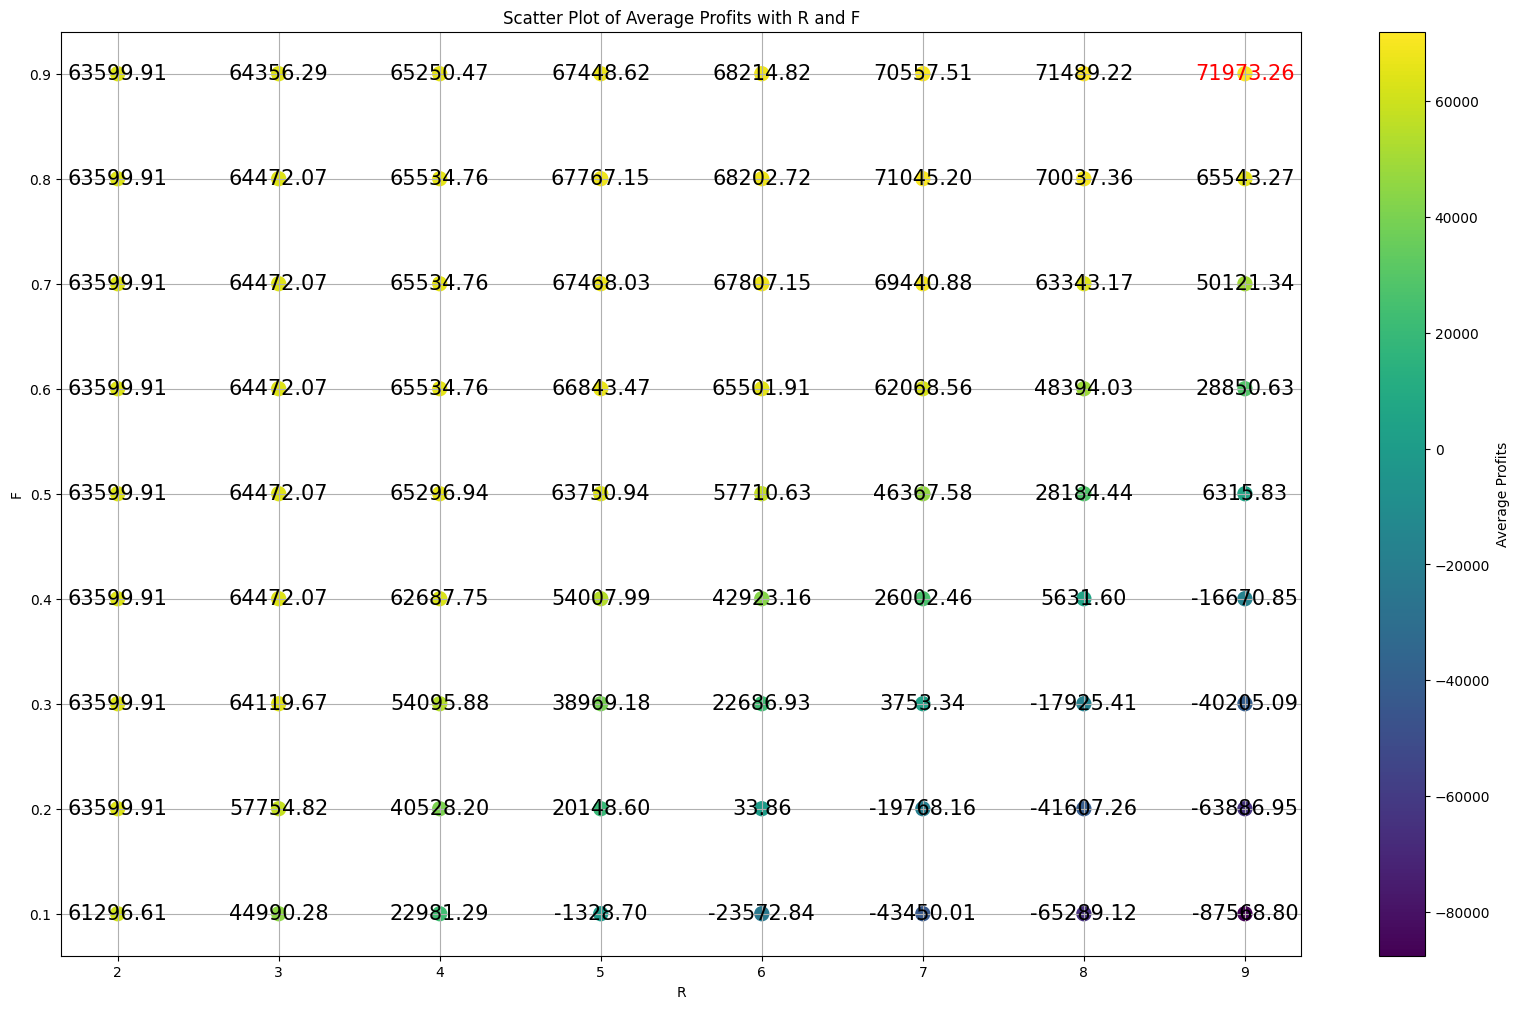

In [193]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_med_50_202411060248.png


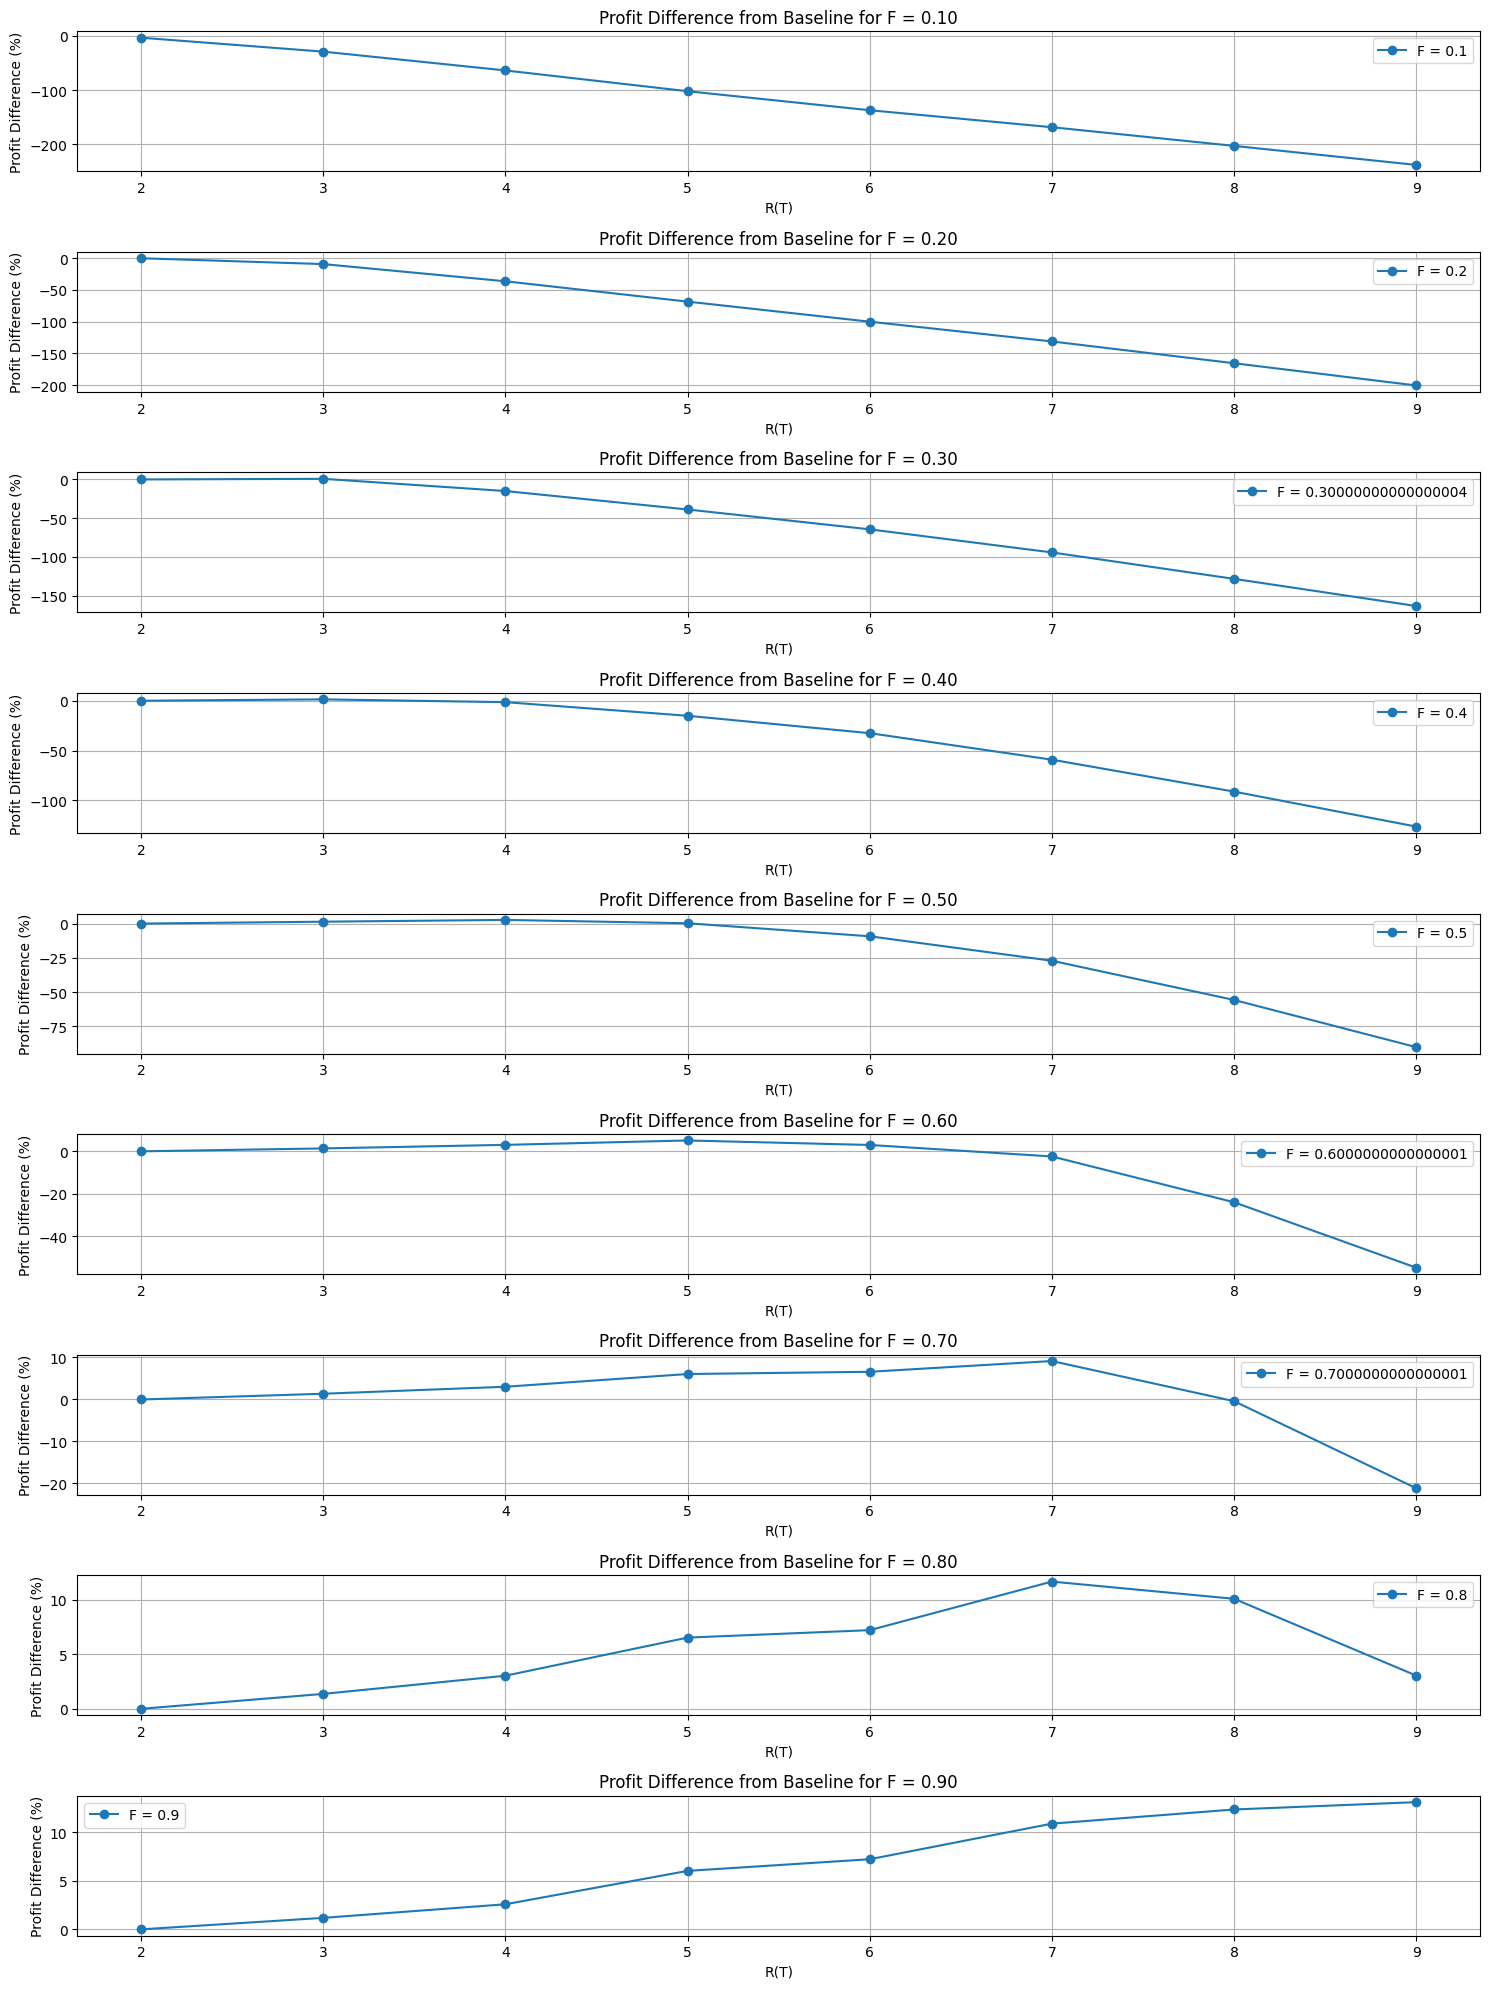

In [194]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(assigned_Fs):
    plt.subplot(len(assigned_Fs), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### (2)Grid for Fixed Rk & Flexible F


In [195]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=assigned_Ts,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1040 rows, 1043 columns and 3400 nonzeros
Model fingerprint: 0xd8657ebd
Model has 40 general constraints
Variable types: 723 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 899 rows and 660 columns
Presolve time: 0.01s
Presolved: 141 rows, 383 columns, 901 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 383 continuous, 0 integer (0 binary)

Root relaxation: objective 2.953053e+06, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve removed 900 rows and 663 columns
Presolve time: 0.01s
Presolved: 140 rows, 380 columns, 892 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 380 continuous, 0 integer (0 binary)

Root relaxation: objective 2.964681e+06, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2964681.4917 2964681.49 -0.00%     -    0s

Explored 1 nodes (58 simplex iterations) in 0.11 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 2.96468e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 2.964681491662e+06, best bound 2.964681491662e+06, gap 0.0000%

model.status is optimal: True
model.status is 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



Root relaxation: objective 2.978851e+06, 63 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2978850.6263 2978850.63  0.00%     -    0s

Explored 1 nodes (63 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 2.97885e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 2.978850626309e+06, best bound 2.978850626309e+06, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 157.87903781155435
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 2.2994181614212086
---------------------------

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3009207.9017 3009207.90 -0.00%     -    0s

Explored 1 nodes (70 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 3.00921e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 3.009207901670e+06, best bound 3.009207901670e+06, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 157.87903781155435
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 2.5099892614309716
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3020983.3972 3020983.40 -0.00%     -    0s

Explored 1 nodes (66 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 3.02098e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 3.020983397249e+06, best bound 3.020983397249e+06, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 157.87903781155435
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 3.0625637625359876
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3057262.47    0   32          - 3057262.47      -     -    0s
     0     0 3053343.57    0    1          - 3053343.57      -     -    0s
H    0     0                    3053343.5559 3053343.57  0.00%     -    0s

Explored 1 nodes (97 simplex iterations) in 0.09 seconds (0.01 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 3.05334e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 3.053343555852e+06, best bound 3.053343570868e+06, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 157.87903781155435
Alphas values:
alpha[0]: 0.0
alpha[1]

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1040 rows, 1043 columns and 3400 nonzeros
Model fingerprint: 0x0c9d46d9
Model has 40 general constraints
Variable types: 723 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 240 rows and 40 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
===================== 找不到最佳解 ==================
Model is feasible. Status: 4
Academic license 2563044

R(T)                                                  R  average_profits  \
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     76333.588896   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     75524.584931   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     75230.197542   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     74471.265658   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     74117.037292   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     73826.316463   

   average_losses  average_lefts  average_operation_profits  \
5             0.0      45.250239               78939.518906   
4             0.0      48.577696               78939.518906   
3             0.0      64.516189               78939.518905   
2             0.0      84.829402               78939.518906   
1             0.0     103.651708               78939.518906   
0             0.0     122.456641               78939.518906   

                     alpha_values  \
5   [0.0, 0.0, 5.283868700138175]   
4  [0.0, 0.0, 3.0625637625359876]   
3  [0.0, 0.0, 2.5099892614309716]   
2  [0.0, 0.0, 2.2994181614212086]   
1   [0.0, 0.0, 2.197595366666512]   
0  [0.0, 0.0, 1.6597469239464546]   

                                              F_vars  \
5  [0.8649697249843057, 0.8670659266353056, 0.994...   
4  [0.729421125892661, 0.7662537487579647, 0.9553...   
3  [0.6149247220031023, 0.7334055654667311, 0.914...   
2  [0.6382789727746995, 0.7685012474757479, 0.871...   
1  [0.6011616011772842, 0.742805810842119, 0.9000...   
0  [0.771671525241273, 0.7919618145839225, 0.8402...   

                                             Q0_vars  \
5  [136.56058791664697, 136.8915342163658, 157.08...   
4  [115.16030551535395, 120.97540457340398, 150.8...   
3  [97.08372343638733, 115.78936500152643, 144.40...   
2  [100.77087007701685, 121.33023750845028, 137.6...   
1  [94.91081516312302, 117.2734666965852, 142.096...   
0  [121.83075791166675, 125.03416927000228, 132.6...   

                                             Q1_vars  
5  [13.298060870013217, 39.01585221760712, 39.015...  
4  [39.01583529062269, 39.01585455103134, 39.0159...  
3  [39.01579961603615, 39.01586070484764, 39.0159...  
2  [39.01582487213177, 39.015883568824435, 39.015...  
1  [39.01581121344232, 39.01587758784156, 39.0159...  
0  [39.015907823797846, 39.01591314876086, 39.015...

In [196]:
if results_df_2 is not None:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/med_s2_50_202411060248.pkl


In [197]:
stimulation_results_df_2

R         F       profits  losses      lefts  operation_profits
0   5  0.864970  79072.709298     0.0  53.750942       79072.709298
1   5  0.867066  86679.203539     0.0  24.310244       87316.448378
2   5  0.994953  98791.517715     0.0  13.795980       98791.517715
3   5  0.725971  80578.036704     0.0  32.643880       80578.036704
4   5  0.733347  45109.621966     0.0  55.066950       52158.754324
5   5  0.751821  78954.641498     0.0  17.272733       78954.641498
6   5  0.690770  79392.236275     0.0  27.497961       79392.236275
7   5  0.944587  99918.735829     0.0  50.802358       99918.735829
8   5  0.779115  90284.913157     0.0  30.623123       90284.913157
9   5  0.847000  63325.254870     0.0  45.038119       67888.177649
10  5  0.731060  47760.038337     0.0  80.117672       52734.770887
11  5  0.765795  48397.076109     0.0  69.691216       55504.853243
12  5  0.836277  66608.014897     0.0  55.597589       68818.553037
13  5  0.834240  72047.782492     0.0  37.527905       72047.782492
14  5  0.748216  62891.555042     0.0  27.023527       62891.555042
15  5  0.841923  67828.946466     0.0  44.866424       69800.831756
16  5  0.836789  71501.210311     0.0  31.569275       71501.210311
17  5  0.922779  83437.598162     0.0  54.313345       87894.645220
18  5  0.879776  88747.045040     0.0  46.771964       88747.045040
19  5  0.938382  81328.332037     0.0  38.926419       87455.860605
20  5  0.896157  93145.827446     0.0  27.344659       93145.827446
21  5  0.933918  91584.008496     0.0  42.727878       92407.491304
22  5  0.899011  55945.644729     0.0  67.778651       67963.602833
23  5  0.896583  58743.792996     0.0  61.566702       69174.179026
24  5  0.763727  80939.060062     0.0  18.625294       80939.060062
25  5  0.829672  77154.998744     0.0  65.316235       77154.998744
26  5  0.912865  58301.576467     0.0  69.707776       70243.256859
27  5  0.752847  93163.296630     0.0  62.337655       93163.296630
28  5  0.768388  50095.847651     0.0  50.865373       56496.167566
29  5  0.989815  99256.115076     0.0  41.962102       99256.115076
30  5  0.810259  71659.940306     0.0  21.782266       77564.666492
31  5  0.891975  68070.301397     0.0  52.809983       73483.409851
32  5  0.849874  82267.130192     0.0  34.917608       84431.832028
33  5  0.959372  82079.835950     0.0  70.342582       88660.081138
34  5  0.783580  75661.117692     0.0  78.510361       75661.117692
35  5  0.957451  92414.460992     0.0  40.783925       93751.587578
36  5  0.805752  83349.227318     0.0  30.960126       83349.227318
37  5  0.775235  84768.504013     0.0  39.411799       84768.504013
38  5  0.883600  73384.000527     0.0  32.216674       75508.656696
39  5  0.913315  88704.399422     0.0  62.834274       88704.399422

In [198]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
5     7     76333.588896
4     6     75524.584931
3     5     75230.197542

### (4)Grid for Fixed F & Flexible Rk


In [199]:
assigned_Fs = np.arange(0.1, 1.0, 0.1)

results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = grid_fixed_F_flexible_R(
    assigned_Fs=assigned_Fs,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)


results_df_4

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2288 columns and 5960 nonzeros
Model fingerprint: 0x8aa13130
Model has 280 quadratic constraints
Model has 640 general constraints
Variable types: 1968 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 800 rows a

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/470406146.py:238: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2288 columns and 5960 nonzeros
Model fingerprint: 0xafccad93
Model has 280 quadratic constraints
Model has 640 general constraints
Variable types: 1968 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [2e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 800 rows and 601 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounde

R(T)  average_losses  \
0  [9, 9, 4, 9, 9, 9, 9, 6, 8, 9, 9, 9, 9, 9, 9, ...        0.490506   

   average_lefts  average_operation_profits  average_profits  \
0      35.604004               78694.266154     75619.937673   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [142.09113403039893, 142.09113403039893, 142.0...   

                                             Q1_vars  \
0  [13.582275513410224, 35.110258428826654, 34.57...   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [200]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
    )

Model parameters saved as models/med_s4_50_202411060248.pkl


In [201]:
stimulation_results_df_4

R(T)    F       profits     losses       lefts  operation_profits
0      9  0.9  79072.709298   0.000000   11.738422       79072.709298
1      9  0.9  64845.767952  14.124288   16.692784       80254.304187
2      4  0.9  98791.517715   0.000000   56.809751       98791.517715
3      9  0.9  80578.036704   0.000000   14.791657       80578.036704
4      9  0.9  33271.941632   0.000000  101.048752       52158.754324
5      9  0.9  76238.923555   0.000000   16.470500       78954.641498
6      9  0.9  77842.525023   0.000000   27.540067       79392.236275
7      6  0.9  99918.735829   0.000000   91.478221       99918.735829
8      8  0.9  90284.913157   0.000000   31.680407       90284.913157
9      9  0.9  64630.862979   0.000000   21.612326       67888.177649
10     9  0.9  34423.974758   0.000000  107.273747       52734.770887
11     9  0.9  39964.139471   0.000000   71.204334       55504.853243
12     9  0.9  66591.539059   0.000000   41.281823       68818.553037
13     9  0.9  72047.782492   0.000000   19.900463       72047.782492
14     9  0.9  54737.543068   0.000000   54.215536       62891.555042
15     9  0.9  68556.096496   0.000000   23.060396       69800.831756
16     9  0.9  71501.210311   0.000000    9.689252       71501.210311
17     9  0.9  84505.048010   1.689196    3.400803       87050.047276
18     9  0.9  88747.045040   0.000000   29.087891       88747.045040
19     9  0.9  83649.124697   3.806736    4.513090       85552.492651
20     8  0.9  93145.827446   0.000000    9.450810       93145.827446
21     6  0.9  92407.491304   0.000000   75.984974       92407.491304
22     9  0.9  64382.815957   0.000000   34.775944       67963.602833
23     9  0.9  64756.050199   0.000000   35.797082       69174.179026
24     9  0.9  80482.372990   0.000000   18.056499       80939.060062
25     9  0.9  77154.998744   0.000000   28.945580       77154.998744
26     9  0.9  67452.063976   0.000000   33.387114       70243.256859
27     8  0.9  93163.296630   0.000000   48.539174       93163.296630
28     9  0.9  41946.768116   0.000000   64.304643       56496.167566
29     6  0.9  99256.115076   0.000000   68.923133       99256.115076
30     9  0.9  77506.200952   0.000000    3.306589       77564.666492
31     9  0.9  72320.627333   0.000000   14.344724       73483.409851
32     9  0.9  83406.790689   0.000000   12.708893       84431.832028
33     9  0.9  88660.081138   0.000000   10.885371       88660.081138
34     9  0.9  75152.091865   0.000000   37.073897       75661.117692
35     4  0.9  93751.587578   0.000000  104.828668       93751.587578
36     9  0.9  83349.227318   0.000000   12.281992       83349.227318
37     9  0.9  84768.504013   0.000000   21.322409       84768.504013
38     9  0.9  72830.758926   0.000000   17.630063       75508.656696
39     9  0.9  88704.399422   0.000000   18.122360       88704.399422

Plot saved as plots/result_4_metrics_train_med_50_202411060248.png


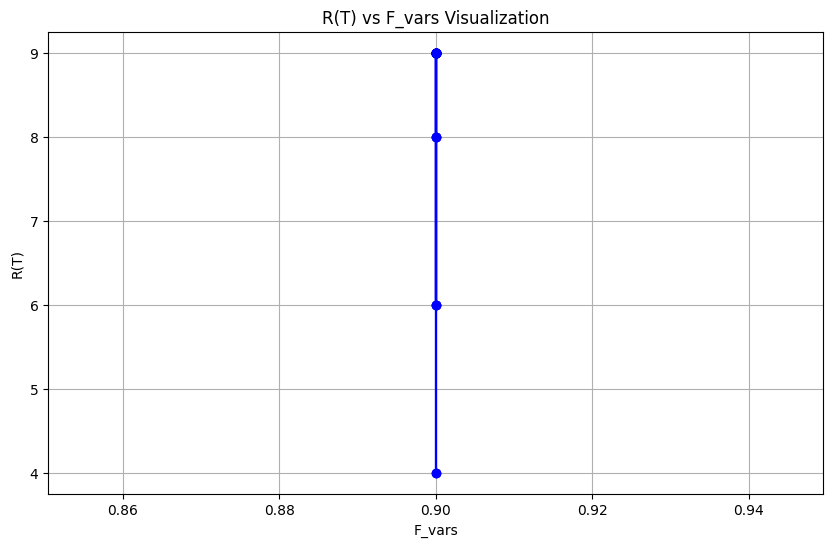

In [202]:
if results_df_4 is not None:

    r_values = results_df_4["R(T)"].explode().values
    f_values = results_df_4["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_4_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_4 is None")

### (3)Fully flexible F & Rk


#### (5)Simple beta with softmax


In [203]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2395 columns and 5600 nonzeros
Model fingerprint: 0x35d57b60
Model has 320 quadratic constraints
Model has 720 general constraints
Variable types: 2075 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/19469133.py:242: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 509 rows and 49848 columns
Presolve time: 1.13s
Presolved: 14629 rows, 55123 columns, 190473 nonzeros
Presolved model has 360 SOS constraint(s)
Presolved model has 2880 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 54485 continuous, 638 integer (638 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.08s

Solved with dual simplex

Root relaxation: objective 3.134293e+06, 2000 iterations, 0.38 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3134292.86    0 2193          - 3134292.86      -     -    4s
     0     0 3134292.86    0 2191          - 3134292.86      -     -    4s
     0     0 3134292.86    0 2191          - 3134292.86      -     -    4s
     0     0 3134292.86    0 2446          - 3134292.86      -     -    6s
     0     0 3134292

In [204]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [205]:
stimulation_results_df_5

#### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [206]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2331 columns and 6080 nonzeros
Model fingerprint: 0x3c2318bd
Model has 280 quadratic constraints
Model has 680 general constraints
Variable types: 2011 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/2383614853.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 469 rows and 43671 columns
Presolve time: 1.17s
Presolved: 3549 rows, 46002 columns, 140633 nonzeros
Presolved model has 320 SOS constraint(s)
Presolved model has 280 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 45364 continuous, 638 integer (638 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.03s

Solved with dual simplex

Root relaxation: objective 3.134293e+06, 1794 iterations, 0.33 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3134292.86    0  449          - 3134292.86      -     -    3s
     0     0 3134292.86    0  448          - 3134292.86      -     -    3s
     0     0 3134292.86    0  497          - 3134292.86      -     -    4s
     0     0 3134292.86    0  496          - 3134292.86      -     -    4s
     0     0 3134292.8

average_profits  average_losses  average_lefts  average_operation_profits  \
0     75720.251253             0.0      60.311753               78939.518906   

      alpha_values                                        beta_values  \
0  [0.0, 0.0, 4.0]  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [207]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

Model parameters saved as models/med_s6_50_202411060248.pkl


In [208]:
stimulation_results_df_6

R(T)  R         F  f_values     Q0_vars    Q1_vars       profits  losses  \
0      9  7  0.982014       4.0  155.039392   0.634017  79072.709298     0.0   
1      5  3  0.982014       4.0  155.039392  19.593504  87316.448378     0.0   
2      4  2  0.982014       4.0  155.039392  21.623531  98791.517715     0.0   
3      9  7  0.982014       4.0  155.039392   4.849393  80578.036704     0.0   
4      9  7  0.500002       4.0   78.939835  25.377674  52158.754324     0.0   
5      7  5  0.982014       4.0  155.039392   2.869891  78954.641498     0.0   
6      7  5  0.690769       4.0  109.057954  39.015789  79392.236275     0.0   
7      4  2  0.716052       4.0  113.049667  39.015924  99918.735829     0.0   
8      6  4  0.982014       4.0  155.039392  25.530434  90284.913157     0.0   
9      4  2  0.982014       4.0  155.039392   0.000000  58256.659153     0.0   
10     9  7  0.500002       4.0   78.939835  14.305978  52734.770887     0.0   
11     7  5  0.982014       4.0  155.039392   0.000000  33490.010342     0.0   
12     9  7  0.982014       4.0  155.039392   0.000000  60117.409930     0.0   
13     9  7  0.982014       4.0  155.039392   0.000000  66575.868840     0.0   
14     9  7  0.982014       4.0  155.039392   0.000000  48263.413939     0.0   
15     9  7  0.982014       4.0  155.039392   0.000000  62081.967367     0.0   
16     9  7  0.982014       4.0  155.039392   0.000000  65482.724479     0.0   
17     6  4  0.982014       4.0  155.039392  20.749898  87894.645220     0.0   
18     9  7  0.982014       4.0  155.039392  22.454698  88747.045040     0.0   
19     9  7  0.982014       4.0  155.039392  11.552503  87455.860605     0.0   
20     9  7  0.952574       4.0  150.391494  34.464252  93145.827446     0.0   
21     4  2  0.952574       4.0  150.391494   6.085037  92407.491304     0.0   
22     9  7  0.982014       4.0  155.039392   0.000000  58407.509521     0.0   
23     9  7  0.982014       4.0  155.039392   0.000000  60828.661907     0.0   
24     4  2  0.982014       4.0  155.039392   0.000000  80939.060062     0.0   
25     9  7  0.982014       4.0  155.039392   0.000000  76790.301343     0.0   
26     9  7  0.982014       4.0  155.039392   0.000000  62966.817573     0.0   
27     9  7  0.982014       4.0  155.039392  31.287201  93163.296630     0.0   
28     7  5  0.982014       4.0  155.039392   0.000000  35472.638987     0.0   
29     3  1  0.982014       4.0  155.039392  39.015924  99256.115076     0.0   
30     6  4  0.982014       4.0  155.039392   0.010379  77564.666492     0.0   
31     5  3  0.982014       4.0  155.039392   0.000000  69447.123557     0.0   
32     2  0  0.982014       4.0  155.039392  13.824272  84431.832028     0.0   
33     9  7  0.982014       4.0  155.039392  22.280770  88660.081138     0.0   
34     7  5  0.982014       4.0  155.039392   0.000000  73802.539239     0.0   
35     9  7  0.982014       4.0  155.039392  32.463783  93751.587578     0.0   
36     9  7  0.982014       4.0  155.039392   7.529808  83349.227318     0.0   
37     9  7  0.982014       4.0  155.039392  14.497616  84768.504013     0.0   
38     7  5  0.982014       4.0  155.039392   0.227233  73384.000527     0.0   
39     9  7  0.982014       4.0  155.039392  22.369407  88704.399422     0.0   

         lefts  operation_profits  
0    24.686681       79072.709298  
1    81.142113       87316.448378  
2    69.758010       98791.517715  
3    27.739915       80578.036704  
4     0.123828       52158.754324  
5    53.418602       78954.641498  
6    27.498096       79392.236275  
7   115.365304       99918.735829  
8    59.060944       90284.913157  
9   117.438269       67888.177649  
10   19.724585       52734.770887  
11  133.641822       55504.853243  
12   67.178340       68818.553037  
13   43.075097       72047.782492  
14   80.112052       62891.555042  
15   48.956913       69800.831756  
16   33.763195       71501.210311  
17   82.546491       87894.645220  
18   36.446510       88747.045040  
19 

#### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [209]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = fully_flexible_simple_beta_with_softmax_3(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_3

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/2365629000.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2331 columns and 6360 nonzeros
Model fingerprint: 0x6c1bb675
Model has 280 quadratic constraints
Model has 680 general constraints
Variable types: 2011 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 749 rows and 43951 columns
Presolve time: 1.05s
Presolved: 3829 rows, 46282 columns, 141473 nonzeros
Presolved model has 320 SOS constraint(s)
Presolved model has 280 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 45644 continuous, 638 integer (638 binary)
Deterministic concurrent LP optimizer: primal and dual

In [210]:
if results_df_3 is not None:

    save_model_parameters(
        f"{model_prefix}_s3",
        alpha_values=results_df_3.iloc[0]["alpha_values"],
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
        f_values=stimulation_results_df_3["f_values"].values,
    )

In [211]:
stimulation_results_df_3

#### (7)Beta with softmax


In [212]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_beta_with_softmax_7(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 200
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2387 columns and 6240 nonzeros
Model fingerprint: 0xde3942b8
Model has 320 quadratic constraints
Model has 720 general constraints
Variable types: 2067 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/790587402.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 829 rows and 50192 columns
Presolve time: 0.99s
Presolved: 10029 rows, 54219 columns, 177073 nonzeros
Presolved model has 360 SOS constraint(s)
Presolved model has 1680 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 53581 continuous, 638 integer (638 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.17s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 3.134293e+06, 2499 iterations, 0.57 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3134292.74    0 1671          - 3134292.74      -     -    2s
     0     0 3134292.74    0 1669          - 3134292.74      -     -    2s
     0     0 3134292.74    0 1669          - 3134292.74      -     -    2s
     0     0 3133236.92    0 1719          - 3133236.92  

In [213]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [214]:
results_df_7

In [215]:
stimulation_results_df_7

## Analysis


### 單次進貨策略


In [216]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 63615.9092202601


### 策略一


In [217]:
# 策略一
results_df_1

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
71     9  0.9  142.091134     71973.256479        3.251441       7.429643   
62     8  0.9  142.091134     71489.219727        3.816507       7.267585   
52     7  0.8  126.303230     71045.196116        4.987628       5.813390   
53     7  0.9  142.091134     70557.508241        4.527924       7.708172   
61     8  0.8  126.303230     70037.358185        5.512288       6.779745   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   31.575808    -41607.261984       80.364521      80.364521   
45     7  0.1   15.787904    -43450.012339       81.593021      81.593021   
64     9  0.2   31.575808    -63886.946479       95.217644      95.217644   
54     8  0.1   15.787904    -65289.117655       96.152424      96.152424   
63     9  0.1   15.787904    -87568.802151      111.005547     111.005547   

    average_operation_profits  baseline_profit  profit_diff_percent  
71               77313.798323      63615.90922            13.137197  
62               77031.265469      63615.90922            12.376323  
52               76445.705131      63615.90922            11.678347  
53               76675.556677      63615.90922            10.911734  
61               76183.374788      63615.90922            10.094093  
..                        ...              ...                  ...  
55               38757.258609      63615.90922          -165.403863  
45               38143.008491      63615.90922          -168.300544  
64               31330.697111      63615.90922          -200.426053  
54               30863.306719      63615.90922          -202.630173  
63               23436.745220      63615.90922          -237.652363  

[72 rows x 9 columns]

In [218]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：40395.19122814051
策略1最佳策略在：R=9.0, F=0.9
策略1最佳策略之下最大利潤為：71973.25647930575


### 策略二


In [219]:
# 策略二
results_df_2

R(T)                                                  R  average_profits  \
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     76333.588896   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     75524.584931   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     75230.197542   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     74471.265658   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     74117.037292   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     73826.316463   

   average_losses  average_lefts  average_operation_profits  \
5             0.0      45.250239               78939.518906   
4             0.0      48.577696               78939.518906   
3             0.0      64.516189               78939.518905   
2             0.0      84.829402               78939.518906   
1             0.0     103.651708               78939.518906   
0             0.0     122.456641               78939.518906   

                     alpha_values  \
5   [0.0, 0.0, 5.283868700138175]   
4  [0.0, 0.0, 3.0625637625359876]   
3  [0.0, 0.0, 2.5099892614309716]   
2  [0.0, 0.0, 2.2994181614212086]   
1   [0.0, 0.0, 2.197595366666512]   
0  [0.0, 0.0, 1.6597469239464546]   

                                              F_vars  \
5  [0.8649697249843057, 0.8670659266353056, 0.994...   
4  [0.729421125892661, 0.7662537487579647, 0.9553...   
3  [0.6149247220031023, 0.7334055654667311, 0.914...   
2  [0.6382789727746995, 0.7685012474757479, 0.871...   
1  [0.6011616011772842, 0.742805810842119, 0.9000...   
0  [0.771671525241273, 0.7919618145839225, 0.8402...   

                                             Q0_vars  \
5  [136.56058791664697, 136.8915342163658, 157.08...   
4  [115.16030551535395, 120.97540457340398, 150.8...   
3  [97.08372343638733, 115.78936500152643, 144.40...   
2  [100.77087007701685, 121.33023750845028, 137.6...   
1  [94.91081516312302, 117.2734666965852, 142.096...   
0  [121.83075791166675, 125.03416927000228, 132.6...   

                                             Q1_vars  
5  [13.298060870013217, 39.01585221760712, 39.015...  
4  [39.01583529062269, 39.01585455103134, 39.0159...  
3  [39.01579961603615, 39.01586070484764, 39.0159...  
2  [39.01582487213177, 39.015883568824435, 39.015...  
1  [39.01581121344232, 39.01587758784156, 39.0159...  
0  [39.015907823797846, 39.01591314876086, 39.015...

In [220]:
stimulation_results_df_2

R         F       profits  losses      lefts  operation_profits
0   5  0.864970  79072.709298     0.0  53.750942       79072.709298
1   5  0.867066  86679.203539     0.0  24.310244       87316.448378
2   5  0.994953  98791.517715     0.0  13.795980       98791.517715
3   5  0.725971  80578.036704     0.0  32.643880       80578.036704
4   5  0.733347  45109.621966     0.0  55.066950       52158.754324
5   5  0.751821  78954.641498     0.0  17.272733       78954.641498
6   5  0.690770  79392.236275     0.0  27.497961       79392.236275
7   5  0.944587  99918.735829     0.0  50.802358       99918.735829
8   5  0.779115  90284.913157     0.0  30.623123       90284.913157
9   5  0.847000  63325.254870     0.0  45.038119       67888.177649
10  5  0.731060  47760.038337     0.0  80.117672       52734.770887
11  5  0.765795  48397.076109     0.0  69.691216       55504.853243
12  5  0.836277  66608.014897     0.0  55.597589       68818.553037
13  5  0.834240  72047.782492     0.0  37.527905       72047.782492
14  5  0.748216  62891.555042     0.0  27.023527       62891.555042
15  5  0.841923  67828.946466     0.0  44.866424       69800.831756
16  5  0.836789  71501.210311     0.0  31.569275       71501.210311
17  5  0.922779  83437.598162     0.0  54.313345       87894.645220
18  5  0.879776  88747.045040     0.0  46.771964       88747.045040
19  5  0.938382  81328.332037     0.0  38.926419       87455.860605
20  5  0.896157  93145.827446     0.0  27.344659       93145.827446
21  5  0.933918  91584.008496     0.0  42.727878       92407.491304
22  5  0.899011  55945.644729     0.0  67.778651       67963.602833
23  5  0.896583  58743.792996     0.0  61.566702       69174.179026
24  5  0.763727  80939.060062     0.0  18.625294       80939.060062
25  5  0.829672  77154.998744     0.0  65.316235       77154.998744
26  5  0.912865  58301.576467     0.0  69.707776       70243.256859
27  5  0.752847  93163.296630     0.0  62.337655       93163.296630
28  5  0.768388  50095.847651     0.0  50.865373       56496.167566
29  5  0.989815  99256.115076     0.0  41.962102       99256.115076
30  5  0.810259  71659.940306     0.0  21.782266       77564.666492
31  5  0.891975  68070.301397     0.0  52.809983       73483.409851
32  5  0.849874  82267.130192     0.0  34.917608       84431.832028
33  5  0.959372  82079.835950     0.0  70.342582       88660.081138
34  5  0.783580  75661.117692     0.0  78.510361       75661.117692
35  5  0.957451  92414.460992     0.0  40.783925       93751.587578
36  5  0.805752  83349.227318     0.0  30.960126       83349.227318
37  5  0.775235  84768.504013     0.0  39.411799       84768.504013
38  5  0.883600  73384.000527     0.0  32.216674       75508.656696
39  5  0.913315  88704.399422     0.0  62.834274       88704.399422

In [221]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：74917.16513032088
策略2最佳策略在：R=7, F為彈性
策略2最佳策略之下最大利潤為：76333.58889630993


### 策略三


In [222]:
# 策略三
results_df_3

In [223]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


### 策略四


In [224]:
results_df_4

R(T)  average_losses  \
0  [9, 9, 4, 9, 9, 9, 9, 6, 8, 9, 9, 9, 9, 9, 9, ...        0.490506   

   average_lefts  average_operation_profits  average_profits  \
0      35.604004               78694.266154     75619.937673   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [142.09113403039893, 142.09113403039893, 142.0...   

                                             Q1_vars  \
0  [13.582275513410224, 35.110258428826654, 34.57...   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [225]:
stimulation_results_df_4

R(T)    F       profits     losses       lefts  operation_profits
0      9  0.9  79072.709298   0.000000   11.738422       79072.709298
1      9  0.9  64845.767952  14.124288   16.692784       80254.304187
2      4  0.9  98791.517715   0.000000   56.809751       98791.517715
3      9  0.9  80578.036704   0.000000   14.791657       80578.036704
4      9  0.9  33271.941632   0.000000  101.048752       52158.754324
5      9  0.9  76238.923555   0.000000   16.470500       78954.641498
6      9  0.9  77842.525023   0.000000   27.540067       79392.236275
7      6  0.9  99918.735829   0.000000   91.478221       99918.735829
8      8  0.9  90284.913157   0.000000   31.680407       90284.913157
9      9  0.9  64630.862979   0.000000   21.612326       67888.177649
10     9  0.9  34423.974758   0.000000  107.273747       52734.770887
11     9  0.9  39964.139471   0.000000   71.204334       55504.853243
12     9  0.9  66591.539059   0.000000   41.281823       68818.553037
13     9  0.9  72047.782492   0.000000   19.900463       72047.782492
14     9  0.9  54737.543068   0.000000   54.215536       62891.555042
15     9  0.9  68556.096496   0.000000   23.060396       69800.831756
16     9  0.9  71501.210311   0.000000    9.689252       71501.210311
17     9  0.9  84505.048010   1.689196    3.400803       87050.047276
18     9  0.9  88747.045040   0.000000   29.087891       88747.045040
19     9  0.9  83649.124697   3.806736    4.513090       85552.492651
20     8  0.9  93145.827446   0.000000    9.450810       93145.827446
21     6  0.9  92407.491304   0.000000   75.984974       92407.491304
22     9  0.9  64382.815957   0.000000   34.775944       67963.602833
23     9  0.9  64756.050199   0.000000   35.797082       69174.179026
24     9  0.9  80482.372990   0.000000   18.056499       80939.060062
25     9  0.9  77154.998744   0.000000   28.945580       77154.998744
26     9  0.9  67452.063976   0.000000   33.387114       70243.256859
27     8  0.9  93163.296630   0.000000   48.539174       93163.296630
28     9  0.9  41946.768116   0.000000   64.304643       56496.167566
29     6  0.9  99256.115076   0.000000   68.923133       99256.115076
30     9  0.9  77506.200952   0.000000    3.306589       77564.666492
31     9  0.9  72320.627333   0.000000   14.344724       73483.409851
32     9  0.9  83406.790689   0.000000   12.708893       84431.832028
33     9  0.9  88660.081138   0.000000   10.885371       88660.081138
34     9  0.9  75152.091865   0.000000   37.073897       75661.117692
35     4  0.9  93751.587578   0.000000  104.828668       93751.587578
36     9  0.9  83349.227318   0.000000   12.281992       83349.227318
37     9  0.9  84768.504013   0.000000   21.322409       84768.504013
38     9  0.9  72830.758926   0.000000   17.630063       75508.656696
39     9  0.9  88704.399422   0.000000   18.122360       88704.399422

In [226]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F_vars'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略在：
R為彈性, F=0.9
策略4最佳策略之下最大利潤(Avg profit)為：75619.93767295827


### 策略五


In [227]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


### 策略六


In [228]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略在：
R=4.0, 
F=0.716052418178428
策略6最佳策略之下最大利潤(Avg profit)為：99918.73582866971


### 策略七


In [229]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


### 比較&分析


#### 不同策略 Scatter


Plot saved as plots/plot_strategies_profits_scatter_train_med_50_202411060248.png


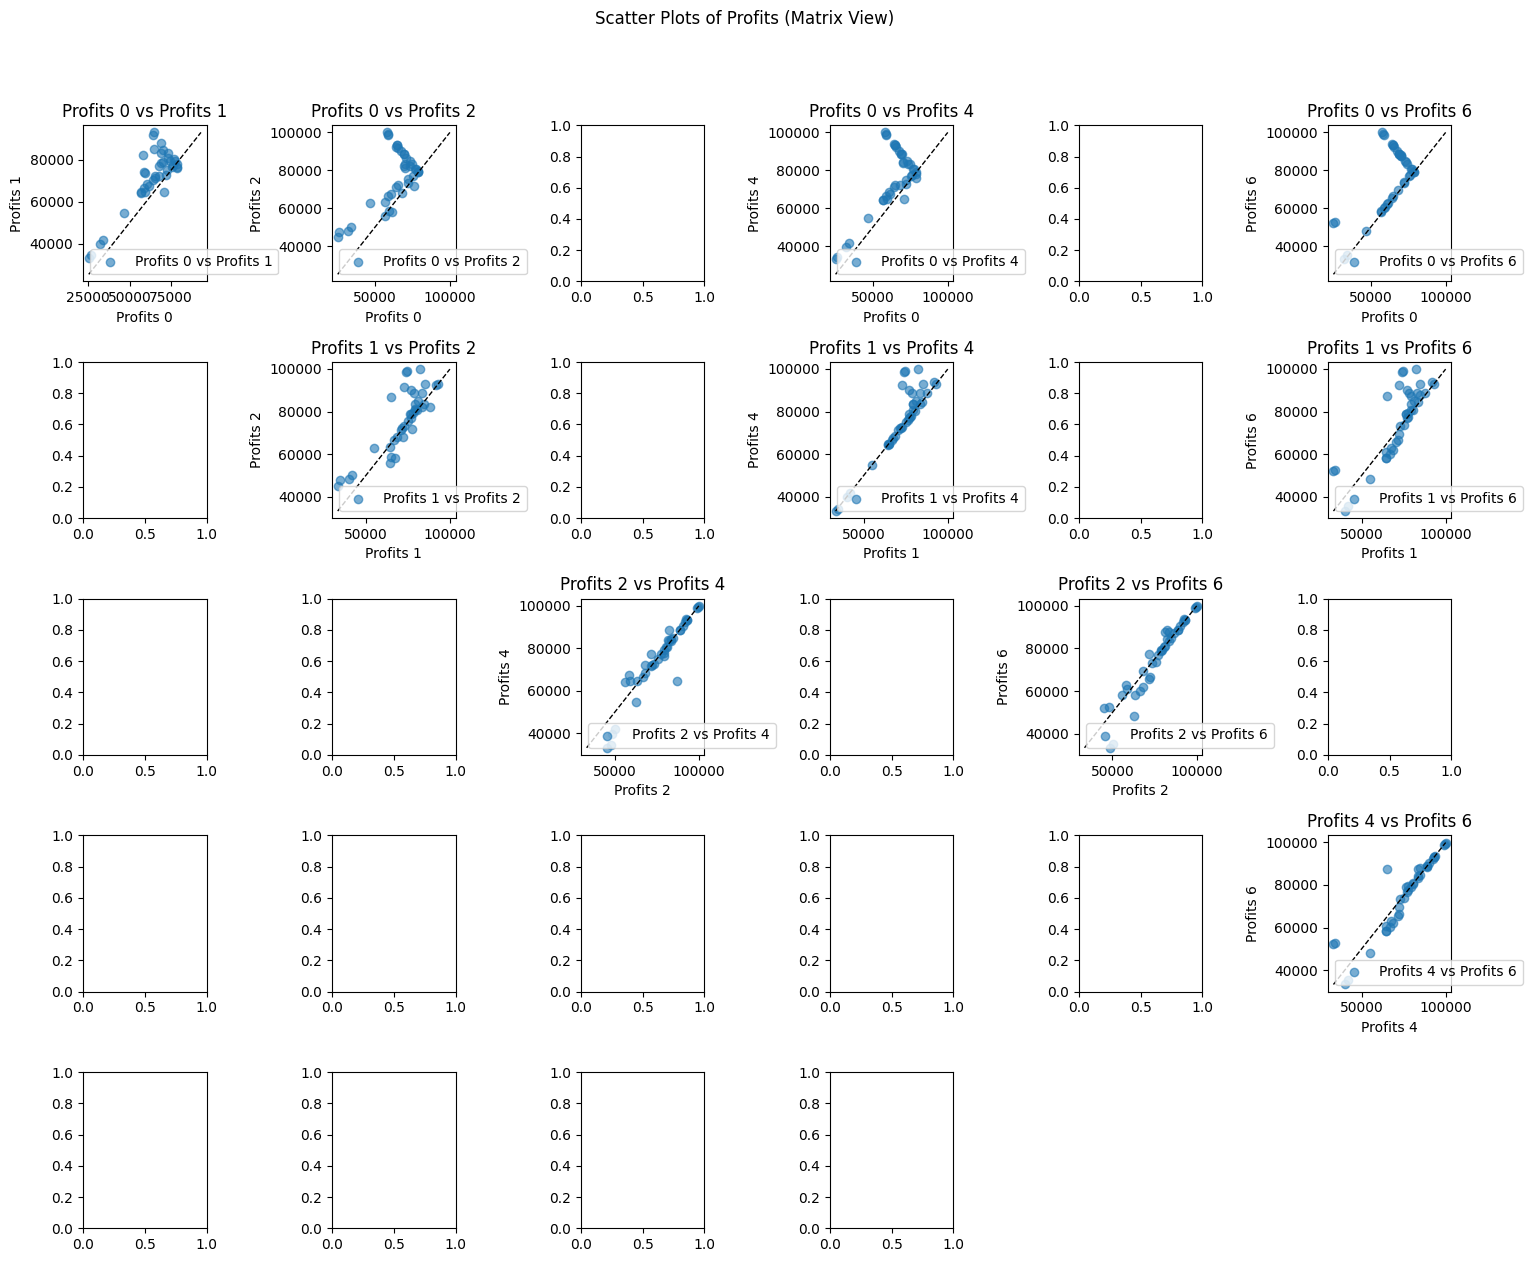

In [230]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

#### 最大利潤比較


Baseline is: 63615.9092202601
S1's profit: 71973.25647930575
S2's profit: 76333.58889630993
S3's profit: -1
S4's profit: 75619.93767295827
S5's profit: -1
S6's profit: 99918.73582866971
S7's profit: -1
Plot saved as plots/plot_relative_profit_deviation_train_med_50_202411060248.png


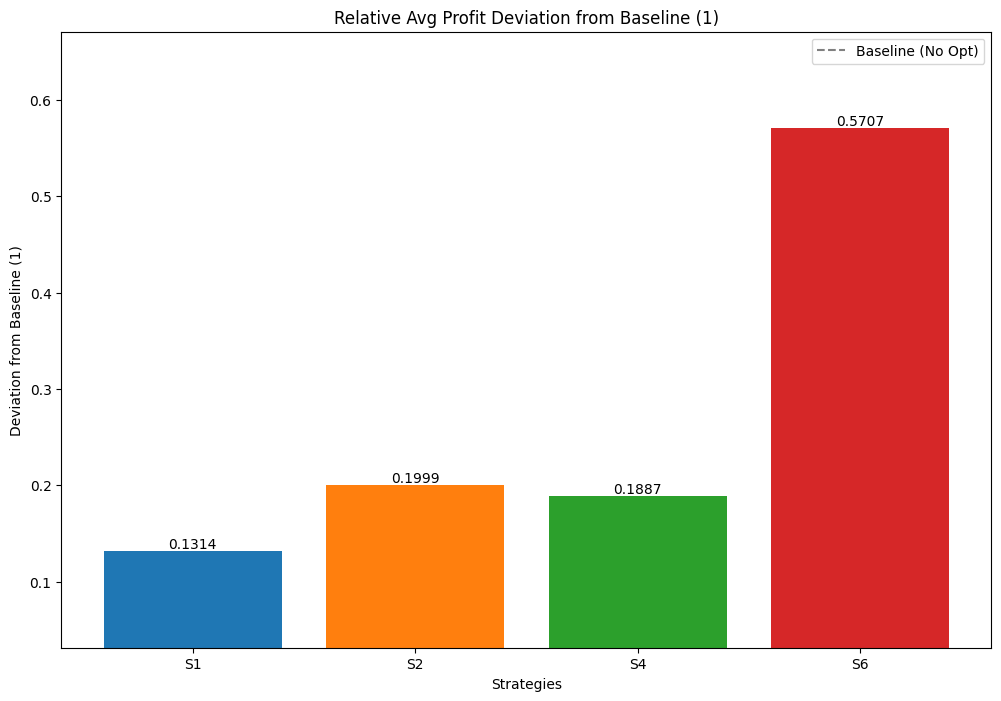

In [231]:
# 使用範例
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

### Preparation


In [232]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7

## Testing


### Setting reasonable parameters


In [233]:
status = "test"

In [234]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
50.0 percentile of sum: 157.87903781155435
Q_star: 157.87903781155435


In [235]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)
Qk_hat_df_test

mu_matrix: [20.75665711 14.34484398 17.38127829 18.52730663 11.42688317  9.24288943
 11.70768751 12.25567027 13.84425952 16.41099414]
covariance_matrix: 
[[ 45.40469575  18.73811153  39.30501323  20.67578616 -35.62612054
  -16.00211943  -2.957299   -18.35898051 -21.7146276   29.43096133]
 [ 18.73811153  34.82844892  16.07839426   5.60415404 -24.91005192
  -10.26109562  -2.73677955  -5.11475935   5.55111984   2.42411329]
 [ 39.30501323  16.07839426  44.02573794   6.16401855 -32.5496682
  -17.43411848 -12.06416746  -4.4870991  -28.25565005  22.54052033]
 [ 20.67578616   5.60415404   6.16401855  62.18465648 -58.57183202
   -0.47890101  30.38628019 -58.25410716   6.45445934  28.62830356]
 [-35.62612054 -24.91005192 -32.5496682  -58.57183202 108.83020946
   18.67035248  -5.27246364  57.40856123   2.5746068  -23.92308784]
 [-16.00211943 -10.26109562 -17.43411848  -0.47890101  18.67035248
   27.42921422   9.35077218   9.26680059  -3.41436356 -19.02113534]
 [ -2.957299    -2.73677955 -12.06416

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  145.671701  149.659575  160.455531  160.272296  166.428678  166.394414   
1  156.019522  156.983159  150.207436  150.478364  147.335605  147.324038   
2  132.883997  130.050526  132.546526  133.285166  118.194070  118.158129   
3  146.082782  143.682321  147.842943  147.527438  152.620629  152.608304   
4  143.242628  143.420467  146.474542  146.423136  147.347647  147.421038   
5  150.776547  150.492276  147.059729  146.756890  146.381487  146.255605   
6  133.607813  134.299209  127.919899  127.033033  121.205221  121.239397   
7  155.347823  159.181535  159.314978  159.528649  144.715204  144.766789   
8  139.365266  141.135555  135.792199  136.387975  158.326739  158.340470   
9  155.986622  150.080078  151.370916  151.291753  156.429420  156.476516   

    Qk_hat_k8   Qk_hat_k9  
0  166.293830  163.112355  
1  147.870677  142.961550  
2  118.227469  117.538335  
3  155.845977  158.089034  
4  144.264385  145.400251  
5  144.407204  147.207475  
6  121.690110  120.379833  
7  145.718874  149.229106  
8  158.734677  160.201228  
9  155.931499  154.865532

### Run all the strategies


Baseline

In [236]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=157.87903781155435
--------------------------------------------------
Day 1
Demand      : 20.581832507042204
Sales       : 20.581832507042204
Loss        : 0
Left        : 137.29720530451215
Inventory   : 137.29720530451215
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 21.070175044749547
Sales       : 21.070175044749547
Loss        : 0
Left        : 116.2270302597626
Inventory   : 116.2270302597626
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 11.051923126831664
Sales       : 11.051923126831664
Loss        : 0
Left        : 105.17510713293093
Inventory   : 105.17510713293093
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 27.32249437056407
Sales       : 27.32249437056407
Loss        : 0
Left        : 77.85261276236

In [237]:
test_stimulation_df_baseline

losses      lefts  operation_profits       profits
0  3.645328   0.000000       78939.518906  77116.855089
1  0.000000  12.086023       72896.507358  66853.495810
2  0.000000  40.797553       58540.742527  38141.966148
3  3.547282   0.000000       78939.518906  77165.877854
4  0.000000   8.680378       74599.329782  70259.140658
5  0.000000  10.942639       73468.199429  67996.879953
6  0.000000  38.931634       59473.702068  40007.885230
7  0.000000  10.395905       73741.566364  68543.613823
8  1.128090   0.000000       78939.518906  78375.473693
9  0.000000   6.292246       75793.395977  72647.273048

S1

In [238]:
results_df_1

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
71     9  0.9  142.091134     71973.256479        3.251441       7.429643   
62     8  0.9  142.091134     71489.219727        3.816507       7.267585   
52     7  0.8  126.303230     71045.196116        4.987628       5.813390   
53     7  0.9  142.091134     70557.508241        4.527924       7.708172   
61     8  0.8  126.303230     70037.358185        5.512288       6.779745   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   31.575808    -41607.261984       80.364521      80.364521   
45     7  0.1   15.787904    -43450.012339       81.593021      81.593021   
64     9  0.2   31.575808    -63886.946479       95.217644      95.217644   
54     8  0.1   15.787904    -65289.117655       96.152424      96.152424   
63     9  0.1   15.787904    -87568.802151      111.005547     111.005547   

    average_operation_profits  baseline_profit  profit_diff_percent  
71               77313.798323      63615.90922            13.137197  
62               77031.265469      63615.90922            12.376323  
52               76445.705131      63615.90922            11.678347  
53               76675.556677      63615.90922            10.911734  
61               76183.374788      63615.90922            10.094093  
..                        ...              ...                  ...  
55               38757.258609      63615.90922          -165.403863  
45               38143.008491      63615.90922          -168.300544  
64               31330.697111      63615.90922          -200.426053  
54               30863.306719      63615.90922          -202.630173  
63               23436.745220      63615.90922          -237.652363  

[72 rows x 9 columns]

In [239]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 9
Q_star 為 157.87903781155435
期初庫存 Q0: 142.09113403039893
重新估計量 Qk_hat: 163.11235529314152
訂貨量 Q1 為 21.021221262742586

第一階段：期初庫存 Q0: 142.09113403039893，需求量為 128.29907798061566，Sold_0 為 128.29907798061566，Left_0 為 13.79205604978327，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 34.813277312525855，需求量為 33.22528746494657，Sold_1 為 33.22528746494657，Left_1 為 1.587989847579287，Lost_1 為 0

統計結果：Sold 為 161.52436544556224, Lost 為 0 Left_Penalty_Cost 為 793.9949237896435，Lost_Penalty_Cost 為 0，Profit 為 79968.18779899148
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 9
Q_star 為 157.87903781155435
期初庫存 Q0: 142.09113403039893
重新估計量 Qk_hat: 142.96154972692784
訂貨量 Q1 為 0.8704156965289087

第一階段：期初庫存 Q0: 142.09113403039893，需求量為 122.07801197502661，Sold_0 為 122.07801197502661，Left_0 為 20.01312205537232，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 20.88353775190123，需求量為 23.71500274100708，Sold_1 為 20.88353775190123，Left_1 為 0.0，Lost_1 為 2.83146498910585

統計結果：Sold 為 142.96154972692784, L

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
0     9  0.9  142.091134     69140.956154        0.996716       5.623126   

   average_operation_profits  
0               72450.877081

S2

In [240]:
results_df_2

R(T)                                                  R  average_profits  \
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     76333.588896   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     75524.584931   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     75230.197542   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     74471.265658   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     74117.037292   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     73826.316463   

   average_losses  average_lefts  average_operation_profits  \
5             0.0      45.250239               78939.518906   
4             0.0      48.577696               78939.518906   
3             0.0      64.516189               78939.518905   
2             0.0      84.829402               78939.518906   
1             0.0     103.651708               78939.518906   
0             0.0     122.456641               78939.518906   

                     alpha_values  \
5   [0.0, 0.0, 5.283868700138175]   
4  [0.0, 0.0, 3.0625637625359876]   
3  [0.0, 0.0, 2.5099892614309716]   
2  [0.0, 0.0, 2.2994181614212086]   
1   [0.0, 0.0, 2.197595366666512]   
0  [0.0, 0.0, 1.6597469239464546]   

                                              F_vars  \
5  [0.8649697249843057, 0.8670659266353056, 0.994...   
4  [0.729421125892661, 0.7662537487579647, 0.9553...   
3  [0.6149247220031023, 0.7334055654667311, 0.914...   
2  [0.6382789727746995, 0.7685012474757479, 0.871...   
1  [0.6011616011772842, 0.742805810842119, 0.9000...   
0  [0.771671525241273, 0.7919618145839225, 0.8402...   

                                             Q0_vars  \
5  [136.56058791664697, 136.8915342163658, 157.08...   
4  [115.16030551535395, 120.97540457340398, 150.8...   
3  [97.08372343638733, 115.78936500152643, 144.40...   
2  [100.77087007701685, 121.33023750845028, 137.6...   
1  [94.91081516312302, 117.2734666965852, 142.096...   
0  [121.83075791166675, 125.03416927000228, 132.6...   

                                             Q1_vars  
5  [13.298060870013217, 39.01585221760712, 39.015...  
4  [39.01583529062269, 39.01585455103134, 39.0159...  
3  [39.01579961603615, 39.01586070484764, 39.0159...  
2  [39.01582487213177, 39.015883568824435, 39.015...  
1  [39.01581121344232, 39.01587758784156, 39.0159...  
0  [39.015907823797846, 39.01591314876086, 39.015...

In [241]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 5


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/1149000371.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left                   alpha_values  \
0     66077.230016           0.0           0.0  [0.0, 0.0, 5.283868700138175]   

   R(T)  
0     7

In [242]:
test_stimulation_results_df_2

F  R(T)      Sold_0     Left_0  Lost_0     Sold_1     Left_1  \
0  0.994953     7  104.041222  53.040974     0.0  57.483143   4.870049   
1  0.994953     7  101.496345  55.585851     0.0  44.296670  11.289182   
2  0.994953     7   70.059481  87.022715     0.0  47.022004  40.000711   
3  0.994953     7   95.359275  61.722921     0.0  61.722921   0.000000   
4  0.994953     7   84.839872  72.242324     0.0  64.358788   7.883537   
5  0.994953     7  104.622967  52.459229     0.0  42.313432  10.145797   
6  0.994953     7   67.185204  89.896993     0.0  51.762200  38.134792   
7  0.994953     7   93.942018  63.140179     0.0  53.541115   9.599064   
8  0.994953     7   95.048779  62.033418     0.0  63.291691   0.000000   
9  0.994953     7  100.203424  56.878773     0.0  51.383368   5.495404   

     Lost_1       profits          Q0        Q1  
0  0.000000  78327.158411  157.082196  9.312218  
1  0.000000  67251.916561  157.082196  0.000000  
2  0.000000  38540.386899  157.082196  0.000000  
3  4.344124  76369.036352  157.082196  0.000000  
4  0.000000  70657.561409  157.082196  0.000000  
5  0.000000  68395.300703  157.082196  0.000000  
6  0.000000  40406.305981  157.082196  0.000000  
7  0.000000  68942.034574  157.082196  0.000000  
8  0.666659  78836.905473  157.082196  1.258273  
9  0.000000  73045.693799  157.082196  0.000000

S3

In [243]:
results_df_3

In [244]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None:
    alphas = results_df_3.iloc[0]["alpha_values"]
    betas = results_df_3.iloc[0]["beta_values"]

    test_results_df_3, test_stimulation_results_df_3 = (
        cal_test_fully_flexible_simple_beta_with_softmax_3(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_3

In [245]:
test_stimulation_results_df_3

S4

In [246]:
results_df_4

R(T)  average_losses  \
0  [9, 9, 4, 9, 9, 9, 9, 6, 8, 9, 9, 9, 9, 9, 9, ...        0.490506   

   average_lefts  average_operation_profits  average_profits  \
0      35.604004               78694.266154     75619.937673   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [142.09113403039893, 142.09113403039893, 142.0...   

                                             Q1_vars  \
0  [13.582275513410224, 35.110258428826654, 34.57...   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [247]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    assigned_F = results_df_4.iloc[0]["F_vars"]
    betas = results_df_4.iloc[0]["beta_values"]
    test_results_df_4, test_stimulation_results_df_4 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_4

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/2606609425.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     63818.184458           0.0           0.0   

                                         beta_balues    F  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  0.9

In [248]:
test_stimulation_results_df_4

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1     Lost_1  \
0  0.9     2  20.581833  121.509302     0.0  125.089869   0.000000  15.852664   
1  0.9     2  28.559357  113.531777     0.0  117.233658  10.226507   0.000000   
2  0.9     2  10.723310  131.367824     0.0  106.358175  25.009649   0.000000   
3  0.9     2  20.898750  121.192384     0.0  125.184032   0.000000  15.343538   
4  0.9     2  18.709168  123.381966     0.0  124.533459   0.000000   5.956032   
5  0.9     2  24.517350  117.573784     0.0  122.419049   3.840148   0.000000   
6  0.9     2  11.281327  130.809807     0.0  107.666077  23.143730   0.000000   
7  0.9     2  28.041519  114.049615     0.0  119.441614   7.864690   0.000000   
8  0.9     2  15.719964  126.371170     0.0  126.371170   0.000000  16.915994   
9  0.9     2  28.533993  113.557141     0.0  123.052799   4.399830   0.000000   

        profits          Q0         Q1  
0  64909.518532  142.091134   3.580567  
1  67783.253651  142.091134  13.928388  
2  46035.918039  142.091134   0.000000  
3  65369.621739  142.091134   3.991648  
4  68643.297959  142.091134   1.151494  
5  71548.125427  142.091134   8.685413  
6  47901.837121  142.091134   0.000000  
7  69809.221361  142.091134  13.256689  
8  62587.569912  142.091134   0.000000  
9  73593.480837  142.091134  13.895488

S5

In [249]:
results_df_5

In [250]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

S6

In [251]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0     75720.251253             0.0      60.311753               78939.518906   

      alpha_values                                        beta_values  \
0  [0.0, 0.0, 4.0]  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [252]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59041/1094914333.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left     alpha_values  \
0     65741.038895           0.0           0.0  [0.0, 0.0, 4.0]   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [253]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0  0.982014     2  20.581833  134.457560     0.0  134.457560   0.000000   
1  0.982014     2  28.559357  126.480035     0.0  117.233658  10.226507   
2  0.982014     2  10.723310  144.316082     0.0  106.358175  37.957907   
3  0.982014     2  20.898750  134.140642     0.0  134.140642   0.000000   
4  0.982014     2  18.709168  136.330224     0.0  130.489491   5.840733   
5  0.982014     2  24.517350  130.522042     0.0  122.419049   8.102993   
6  0.982014     2  11.281327  143.758065     0.0  107.666077  36.091988   
7  0.982014     2  28.041519  126.997874     0.0  119.441614   7.864690   
8  0.982014     2  15.719964  139.319428     0.0  139.319428   0.000000   
9  0.982014     2  28.533993  126.505399     0.0  123.052799   4.399830   

     Lost_1       profits          Q0       Q1  
0  6.484973  74277.209566  155.039392  0.00000  
1  0.000000  67783.253651  155.039392  0.98013  
2  0.000000  39561.788909  155.039392  0.00000  
3  6.386928  74326.232331  155.039392  0.00000  
4  0.000000  71678.963419  155.039392  0.00000  
5  0.000000  69416.702714  155.039392  0.00000  
6  0.000000  41427.707992  155.039392  0.00000  
7  0.000000  69809.221361  155.039392  0.30843  
8  3.967736  75535.828170  155.039392  0.00000  
9  0.000000  73593.480837  155.039392  0.94723

S7

In [254]:
results_df_7

In [255]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

In [256]:
test_stimulation_results_df_7

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_med_50_202411060248.png


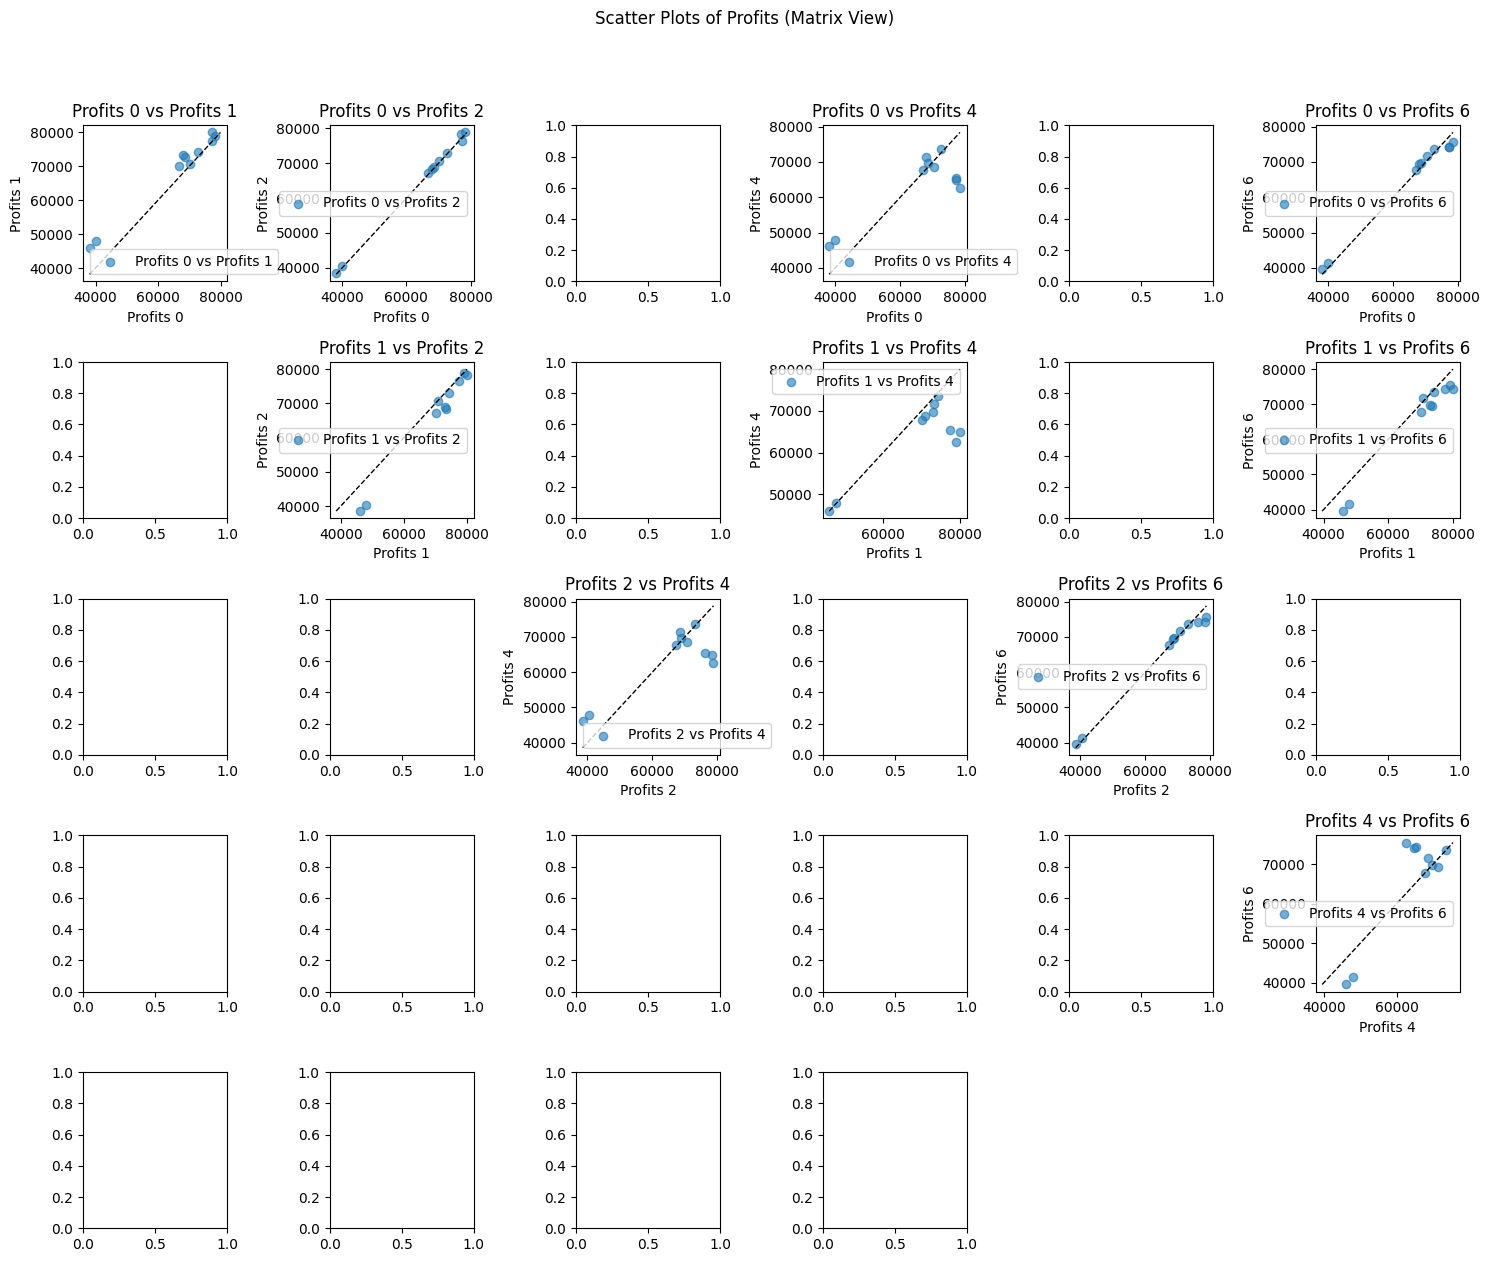

In [257]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 65710.84613057095
S1's profit: 69140.95615449698
S2's profit: 66077.2300162933
S3's profit: -1
S4's profit: 63818.18445770978
S5's profit: -1
S6's profit: 65741.03889496598
S7's profit: -1
Plot saved as plots/plot_relative_profit_deviation_test_med_50_202411060248.png


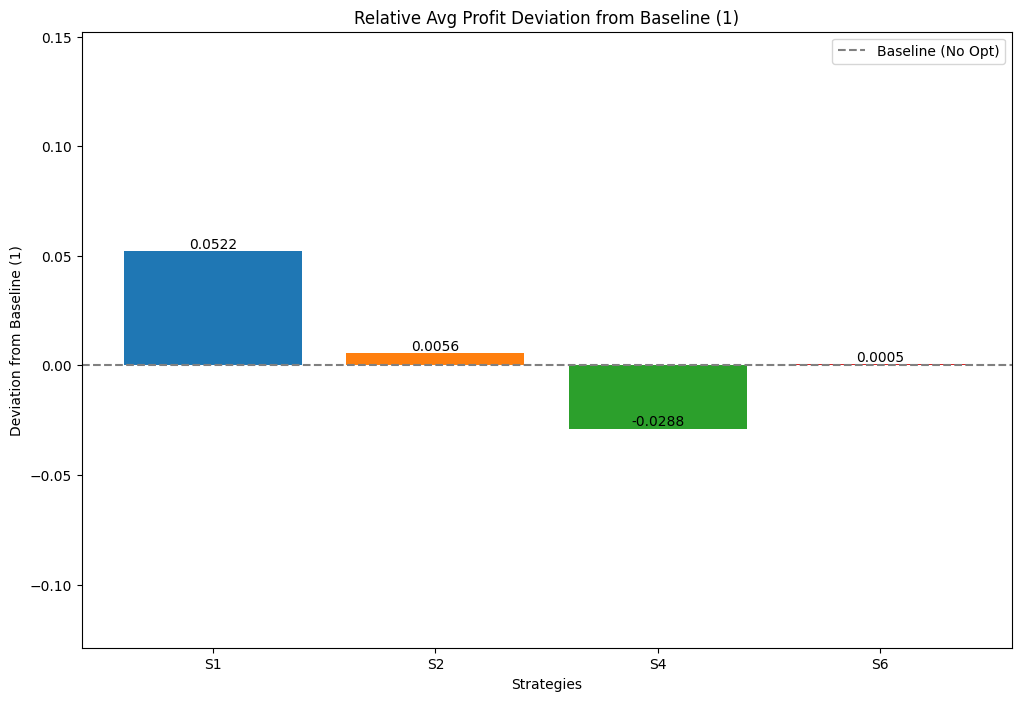

In [258]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_med_50_202411060248.png


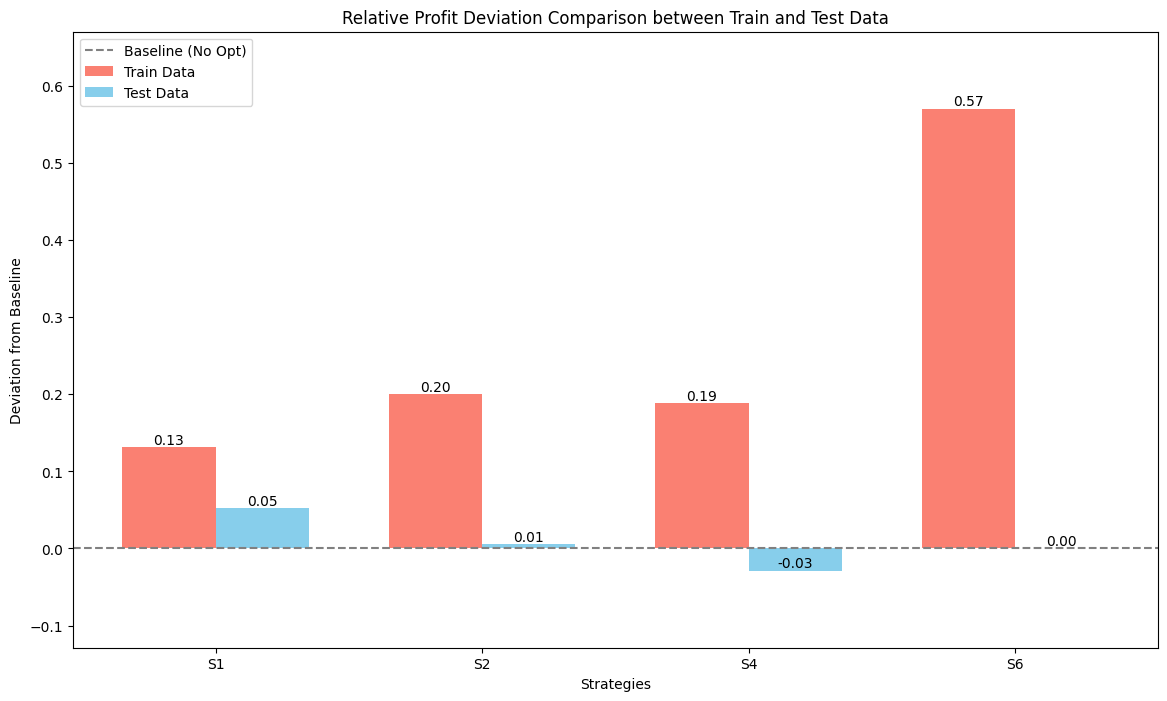

In [259]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [260]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]

# 總和分析


In [261]:
# # Plotting
# plt.figure(figsize=(16, 30))

# # Traverse through different F values to plot merged subplots
# for idx, F in enumerate(assigned_Fs):
#     plt.subplot(len(assigned_Fs), 1, idx + 1)

#     # Select high baseline data corresponding to F
#     subset_high = (
#         high_results_df_1[high_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_high["R"],
#         subset_high["profit_diff_percent"],
#         marker="s",
#         linestyle="-",
#         color="blue",
#         label="High Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_high["R"], subset_high["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="blue", ha="left", va="bottom")

#     # Select low baseline data corresponding to F
#     subset_low = (
#         low_results_df_1[low_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_low["R"],
#         subset_low["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         color="red",
#         label="Low Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_low["R"], subset_low["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="red", ha="right", va="top")

#     plt.xlabel("R")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()
# plt.show()

# Drafts


In [262]:
# def check_values(Q1, Q_hat_adjusted, Q0,
#                  Sold_0, total_demand_up_to_k_minus_1,
#                  Q0_var, Sold_1, total_demand_from_k_to_T,
#                  Q1_plus_left, Left_0, Lost_0, Left_1, Lost_1):

#     i=0
#     print("---------------------------------------")
#     print(f"Start to check the values: ")

#     # 檢查條件 1：Q1_vars[i].X 一定是等於 Q_hats[i].X - Q0_vars[i].X（值為 Q_hat_adjusted） 或是 0
#     if not (Q1 == Q_hat_adjusted or Q1 == 0):
#         print(f"Error: Q1 ({Q1}) should be equal to Q_hat_adjusted ({Q_hat_adjusted}) or 0")
#         i+=1

#     # 檢查條件 2：Sold_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X 或是 Q0_vars[i].X
#     if not (Sold_0 == total_demand_up_to_k_minus_1 or Sold_0 == Q0):
#         print(f"Error: Sold_0 ({Sold_0}) should be equal to total_demand_up_to_k_minus_1 ({total_demand_up_to_k_minus_1}) or Q0 ({Q0})")
#         i+=1

#     # 檢查條件 3：Sold_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X 或是 Q1_plus_lefts[i].X
#     if not (Sold_1 == total_demand_from_k_to_T or Sold_1 == Q1_plus_left):
#         print(f"Error: Sold_1 ({Sold_1}) should be equal to total_demand_from_k_to_T ({total_demand_from_k_to_T}) or Q1_plus_left ({Q1_plus_left})")
#         i+=1

#     # 檢查條件 4：Left_0s[i].X 一定等於 Q0_vars[i].X - Sold_0s[i].X 或是 0
#     if not (Left_0 == Q0 - Sold_0 or Left_0 == 0):
#         print(f"Error: Left_0 ({Left_0}) should be equal to Q0 - Sold_0 ({Q0 - Sold_0}) or 0")
#         i+=1

#     # 檢查條件 5：Left_1s[i].X 一定等於 Q1_plus_lefts[i].X - Sold_1s[i].X 或是 0
#     if not (Left_1 == Q1_plus_left - Sold_1 or Left_1 == 0):
#         print(f"Error: Left_1 ({Left_1}) should be equal to Q1_plus_left - Sold_1 ({Q1_plus_left - Sold_1}) or 0")
#         i+=1

#     # 檢查條件 6：Lost_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X - Q0_vars[i].X 或是 0
#     if not (Lost_0 == total_demand_up_to_k_minus_1 - Q0 or Lost_0 == 0):
#         print(f"Error: Lost_0 ({Lost_0}) should be equal to total_demand_up_to_k_minus_1 - Q0 ({total_demand_up_to_k_minus_1 - Q0}) or 0")
#         i+=1

#     # 檢查條件 7：Lost_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X - Q1_plus_lefts[i].X 或是 0
#     if not (Lost_1 == total_demand_from_k_to_T - Q1_plus_left or Lost_1 == 0):
#         print(f"Error: Lost_1 ({Lost_1}) should be equal to total_demand_from_k_to_T - Q1_plus_left ({total_demand_from_k_to_T - Q1_plus_left}) or 0")
#         i+=1

#     if i == 0:
#         print(f"All Pass!")
#     else:
#         print(f"There are {i} wrongs!")

#     print("---------------------------------------")

In [263]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addConstr(Left_0s[i] >= aux_left_0, name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")
# model.addConstr(Left_0s[i] <= aux_left_0, name=f"Constr_Left_0_3_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addConstr(Lost_0s[i] >= aux_lost_0, name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")
# model.addConstr(Lost_0s[i] <= aux_lost_0, name=f"Constr_Lost_0_3_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - Sold_1s[i], name=f"constr_aux_left_1_{i}")
# model.addConstr(Left_1s[i] >= aux_left_1, name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")
# model.addConstr(Left_1s[i] <= aux_left_1, name=f"Constr_Left_1_3_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addConstr(Lost_1s[i] >= aux_lost_1, name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")
# model.addConstr(Lost_1s[i] <= aux_lost_1, name=f"Constr_Lost_1_3_{i}")


# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [264]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# model.addConstr(Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

# # 計算 Lost_0
# model.addConstr(Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# model.addConstr(Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

# # 計算 Lost_1
# model.addConstr(Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [265]:
# # 計算 Sold_0
# model.addGenConstrMin(Sold_0s[i], [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]], name=f"Sold_0_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addGenConstrMax(Left_0s[i], [aux_left_0], 0.0, f"Left_0_Max_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addGenConstrMax(Lost_0s[i], [aux_lost_0], 0.0, f"Lost_0_Max_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addGenConstrMin(Sold_1s[i], [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],  name=f"Sold_1_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - total_demand_from_k_to_T_vars[i], name=f"constr_aux_left_1_{i}")
# model.addGenConstrMax(Left_1s[i], [aux_left_1], 0.0, f"Left_1_Max_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addGenConstrMax(Lost_1s[i], [aux_lost_1], 0.0, f"Lost_1_Max_{i}")